In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/microsoft-malware-prediction/sample_submission.csv
/kaggle/input/microsoft-malware-prediction/train.csv
/kaggle/input/microsoft-malware-prediction/test.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [3]:

# Load the datasets with low_memory=False
train_data = pd.read_csv("/kaggle/input/microsoft-malware-prediction/train.csv", low_memory=False)
# test_data = pd.read_csv("/kaggle/input/microsoft-malware-prediction/test.csv", low_memory=False)

# Check the first few rows of the training data
# print(train_data.head())


In [4]:
test_data = pd.read_csv("/kaggle/input/microsoft-malware-prediction/test.csv", low_memory=False)

In [5]:
train = train_data
test = test_data

In [6]:
print("Training data shape:", train.shape)
print("Test data shape:", test.shape)

Training data shape: (8921483, 83)
Test data shape: (7853253, 82)


In [7]:
train = train.sample(n=1000000, random_state=42)
test = test.sample(n=1000000, random_state=42)

In [8]:
def downcast_columns(train):
    # Downcast integer columns
    int_cols = train.select_dtypes(include=['int']).columns
    train[int_cols] = train[int_cols].apply(pd.to_numeric, downcast='integer')

    # Downcast float columns
    float_cols = train.select_dtypes(include=['float']).columns
    train[float_cols] = train[float_cols].apply(pd.to_numeric, downcast='float')

    # Downcast non-numerical (object) columns to category
    obj_cols = train.select_dtypes(include=['object']).columns
    train[obj_cols] = train[obj_cols].apply(lambda col: col.astype('category'))

    return train

In [9]:
train_df = downcast_columns(train)
test_df = downcast_columns(test)

In [10]:
train.head()

MachineIdentifier   ProductName EngineVersion  \
8427007  f1cd864e97bae82bdf96523e1a539121  win8defender   1.1.15100.1   
8829090  fd5ba6f5b75325ec0423a6c67cc75942  win8defender   1.1.15100.1   
2731904  4e628391e7cc7c482fb3286f486dbd25  win8defender   1.1.15100.1   
1359513  270a2e9d028144a4df12a9e3da79fba5  win8defender   1.1.15200.1   
236059   06ca8fa8d32c2abdc5b3577d676b3269  win8defender   1.1.15200.1   

              AppVersion  AvSigVersion  IsBeta  RtpStateBitfield  \
8427007  4.18.1807.18075  1.273.1234.0       0               7.0   
8829090  4.18.1807.18075  1.273.1282.0       0               7.0   
2731904   4.9.10586.1106   1.273.781.0       0               7.0   
1359513  4.18.1807.18075  1.275.1639.0       0               7.0   
236059   4.18.1807.18075   1.275.511.0       0               7.0   

         IsSxsPassiveMode  DefaultBrowsersIdentifier  \
8427007                 0                        NaN   
8829090                 0                        NaN   
2731904                 0                        NaN   
1359513                 0                        NaN   
236059                  0                        NaN   

         AVProductStatesIdentifier  ...  Census_FirmwareVersionIdentifier  \
8427007                    53447.0  ...                           19951.0   
8829090                    53447.0  ...                           48753.0   
2731904                    46781.0  ...                           33111.0   
1359513                    53447.0  ...                           48473.0   
236059                     47238.0  ...                            4343.0   

         Census_IsSecureBootEnabled  Census_IsWIMBootEnabled  \
8427007                           0                      NaN   
8829090                           0                      0.0   
2731904                           1                      0.0   
1359513                           1                      NaN   
236059                            1                      NaN   

         Census_IsVirtualDevice  Census_IsTouchEnabled  Census_IsPenCapable  \
8427007                     0.0                      0                    0   
8829090                     0.0                      0                    0   
2731904                     0.0                      1                    1   
1359513                     0.0                      0                    0   
236059                      0.0                      1                    0   

         Census_IsAlwaysOnAlwaysConnectedCapable  Wdft_IsGamer  \
8427007                                      0.0           0.0   
8829090                                      0.0           1.0   
2731904                                      0.0           0.0   
1359513                                      0.0           0.0   
236059                                       0.0           1.0   

        Wdft_RegionIdentifier HasDetections  
8427007                  11.0             1  
8829090                   3.0             0  
2731904                  15.0             0  
1359513                  15.0             1  
236059                   13.0             1  

[5 rows x 83 columns]

In [11]:
train.describe().T

count          mean  \
IsBeta                                             1000000.0  8.000000e-06   
RtpStateBitfield                                    996386.0  6.846598e+00   
IsSxsPassiveMode                                   1000000.0  1.723100e-02   
DefaultBrowsersIdentifier                            48589.0  1.657858e+03   
AVProductStatesIdentifier                           995987.0  4.782922e+04   
AVProductsInstalled                                 995987.0  1.327213e+00   
AVProductsEnabled                                   995987.0  1.020745e+00   
HasTpm                                             1000000.0  9.878200e-01   
CountryIdentifier                                  1000000.0  1.080143e+02   
CityIdentifier                                      963695.0  8.123643e+04   
OrganizationIdentifier                              690840.0  2.485972e+01   
GeoNameIdentifier                                   999980.0  1.696899e+02   
LocaleEnglishNameIdentifier                        1000000.0  1.227192e+02   
OsBuild                                            1000000.0  1.572319e+04   
OsSuite                                            1000000.0  5.751184e+02   
IsProtected                                         996006.0  9.455666e-01   
AutoSampleOptIn                                    1000000.0  2.900000e-05   
SMode                                               939923.0  4.574843e-04   
IeVerIdentifier                                     993419.0  1.266467e+02   
Firewall                                            989696.0  9.783822e-01   
UacLuaenable                                        998804.0  1.372443e+01   
Census_OEMNameIdentifier                            989162.0  2.220290e+03   
Census_OEMModelIdentifier                           988393.0  2.390781e+05   
Census_ProcessorCoreCount                           995359.0  3.991549e+00   
Census_ProcessorManufacturerIdentifier              995359.0  4.531603e+00   
Census_ProcessorModelIdentifier                     995355.0  2.371700e+03   
Census_PrimaryDiskTotalCapacity                     994094.0  5.132442e+05   
Census_SystemVolumeTotalCapacity                    994094.0  3.775430e+05   
Census_HasOpticalDiskDrive                         1000000.0  7.721100e-02   
Census_TotalPhysicalRAM                             990947.0  6.119374e+03   
Census_InternalPrimaryDiagonalDisplaySizeInInches   994763.0  1.667820e+01   
Census_InternalPrimaryDisplayResolutionHorizontal   994775.0  1.548185e+03   
Census_InternalPrimaryDisplayResolutionVertical     994775.0  8.980630e+02   
Census_InternalBatteryNumberOfCharges               969840.0  1.122832e+09   
Census_OSBuildNumber                               1000000.0  1.583811e+04   
Census_OSBuildRevision                             1000000.0  9.691945e+02   
Census_OSInstallLanguageIdentifier                  993377.0  1.459720e+01   
Census_OSUILocaleIdentifier                        1000000.0  6.040393e+01   
Census_IsPortableOperatingSystem                   1000000.0  5.250000e-04   
Census_IsFlightingInternal                          169723.0  1.767586e-05   
Census_IsFlightsDisabled                            981994.0  9.165025e-06   
Census_ThresholdOptIn                               364729.0  2.522421e-04   
Census_FirmwareManufacturerIdentifier               979342.0  4.030351e+02   
Census_FirmwareVersionIdentifier                    981962.0  3.302019e+04   
Census_IsSecureBootEnabled                         1000000.0  4.856220e-01   
Census_IsWIMBootEnabled                             365582.0  2.735364e-06   
Census_IsVirtualDevice                              998159.0  7.113095e-03   
Census_IsTouchEnabled                              1000000.0  1.256870e-01   
Census_IsPenCapable                                1000000.0  3.804600e-02   
Census_IsAlwaysOnAlwaysConnectedCapable             991961.0  5.751738e-02   
Wdft_IsGamer                                        966019.0  2.834623e-01   

In [12]:
test.head()

MachineIdentifier   ProductName EngineVersion  \
7235551  ebdc395690b7b7eb3c0f1e2686b72914  win8defender   1.1.15300.6   
7166348  e997e22c4754b4243152f9a726f8e2e1  win8defender   1.1.15300.6   
2457082  50112327021da2534a652ebaba8b5a2f  win8defender   1.1.15200.1   
3394066  6e9bcec7b18f40226395811f74ae0c66  win8defender   1.1.15300.6   
7539419  f5c13dddc327f631fdd96b8e30d333e5  win8defender   1.1.15300.6   

               AppVersion  AvSigVersion  IsBeta  RtpStateBitfield  \
7235551    4.13.17134.228   1.277.445.0       0               7.0   
7166348     4.12.16299.15   1.277.176.0       0               7.0   
2457082   4.18.1807.18075   1.275.488.0       0               7.0   
3394066  4.14.17639.18041  1.277.1037.0       0               7.0   
7539419       4.18.1809.2  1.277.1053.0       0               7.0   

         IsSxsPassiveMode  DefaultBrowsersIdentifier  \
7235551                 0                        NaN   
7166348                 0                        NaN   
2457082                 0                        NaN   
3394066                 0                        NaN   
7539419                 0                        NaN   

         AVProductStatesIdentifier  ...  \
7235551                    41571.0  ...   
7166348                    43875.0  ...   
2457082                    47238.0  ...   
3394066                    53447.0  ...   
7539419                    53447.0  ...   

         Census_FirmwareManufacturerIdentifier  \
7235551                                  355.0   
7166348                                  556.0   
2457082                                  556.0   
3394066                                  897.0   
7539419                                  142.0   

         Census_FirmwareVersionIdentifier  Census_IsSecureBootEnabled  \
7235551                           19844.0                           0   
7166348                           63103.0                           1   
2457082                           63140.0                           1   
3394066                            7464.0                           0   
7539419                           52458.0                           0   

         Census_IsWIMBootEnabled  Census_IsVirtualDevice  \
7235551                      0.0                     0.0   
7166348                      NaN                     0.0   
2457082                      NaN                     0.0   
3394066                      0.0                     0.0   
7539419                      NaN                     0.0   

         Census_IsTouchEnabled  Census_IsPenCapable  \
7235551                      1                    0   
7166348                      0                    0   
2457082                      0                    0   
3394066                      0                    0   
7539419                      0                    0   

         Census_IsAlwaysOnAlwaysConnectedCapable Wdft_IsGamer  \
7235551                                      0.0          0.0   
7166348                                      0.0          NaN   
2457082                                      0.0          0.0   
3394066                                      0.0          0.0   
7539419                                      0.0          1.0   

        Wdft_RegionIdentifier  
7235551                  11.0  
7166348                   NaN  
2457082                  13.0  
3394066                   2.0  
7539419                   3.0  

[5 rows x 82 columns]

In [13]:
test.describe().T

count          mean  \
IsBeta                                             1000000.0  2.000000e-06   
RtpStateBitfield                                    995911.0  6.852652e+00   
IsSxsPassiveMode                                   1000000.0  1.586200e-02   
DefaultBrowsersIdentifier                            38884.0  1.604991e+03   
AVProductStatesIdentifier                           997022.0  4.945566e+04   
AVProductsInstalled                                 997022.0  1.273209e+00   
AVProductsEnabled                                   997022.0  1.018224e+00   
HasTpm                                             1000000.0  9.917440e-01   
CountryIdentifier                                  1000000.0  1.094706e+02   
CityIdentifier                                      975788.0  8.118996e+04   
OrganizationIdentifier                              683672.0  2.494444e+01   
GeoNameIdentifier                                   999980.0  1.714794e+02   
LocaleEnglishNameIdentifier                        1000000.0  1.222622e+02   
OsBuild                                            1000000.0  1.591787e+04   
OsSuite                                            1000000.0  5.515275e+02   
IsProtected                                         997039.0  9.452789e-01   
AutoSampleOptIn                                    1000000.0  1.800000e-05   
SMode                                               256745.0  3.115932e-03   
IeVerIdentifier                                     993630.0  1.286425e+02   
Firewall                                            992558.0  9.788325e-01   
UacLuaenable                                        999053.0  7.356349e+00   
Census_OEMNameIdentifier                            988516.0  2.233787e+03   
Census_OEMModelIdentifier                           987723.0  2.406517e+05   
Census_ProcessorCoreCount                           992215.0  4.100238e+00   
Census_ProcessorManufacturerIdentifier              992214.0  4.531291e+00   
Census_ProcessorModelIdentifier                     992206.0  2.384849e+03   
Census_PrimaryDiskTotalCapacity                     990581.0  5.023253e+05   
Census_SystemVolumeTotalCapacity                    990581.0  3.576667e+05   
Census_HasOpticalDiskDrive                         1000000.0  6.778800e-02   
Census_TotalPhysicalRAM                             987971.0  6.249453e+03   
Census_InternalPrimaryDiagonalDisplaySizeInInches   994580.0  1.684284e+01   
Census_InternalPrimaryDisplayResolutionHorizontal   994593.0  1.557163e+03   
Census_InternalPrimaryDisplayResolutionVertical     994593.0  9.037446e+02   
Census_InternalBatteryNumberOfCharges               969488.0  1.215201e+09   
Census_OSBuildNumber                               1000000.0  1.600317e+04   
Census_OSBuildRevision                             1000000.0  1.017875e+03   
Census_OSInstallLanguageIdentifier                  992753.0  1.517179e+01   
Census_OSUILocaleIdentifier                        1000000.0  6.294143e+01   
Census_IsPortableOperatingSystem                   1000000.0  6.300000e-04   
Census_IsFlightingInternal                          150068.0  1.999094e-05   
Census_IsFlightsDisabled                            984036.0  2.032446e-06   
Census_ThresholdOptIn                               295961.0  2.398965e-04   
Census_FirmwareManufacturerIdentifier               974611.0  3.966652e+02   
Census_FirmwareVersionIdentifier                    977365.0  3.265724e+04   
Census_IsSecureBootEnabled                         1000000.0  4.508330e-01   
Census_IsWIMBootEnabled                             296849.0  0.000000e+00   
Census_IsVirtualDevice                              997787.0  8.259278e-03   
Census_IsTouchEnabled                              1000000.0  1.185530e-01   
Census_IsPenCapable                                1000000.0  3.821800e-02   
Census_IsAlwaysOnAlwaysConnectedCapable             988614.0  5.473420e-02   
Wdft_IsGamer                                        961539.0  2.974149e-01   

In [14]:
# # Plot histograms for numerical columns
# train.hist(bins=30, figsize=(20, 15))
# plt.tight_layout()
# plt.show()

# # KDE plots for more visual analysis of skewness
# for col in train.select_dtypes(include=['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns: # Removed 'category', 'object' from include
#     plt.figure()
#     sns.kdeplot(data=train[col], shade=True)
#     plt.title(f'Distribution of {col}')
#     plt.show()

In [15]:
print("Train: ",train.duplicated().any())
print("Test:  ",test.duplicated().any())

Train:  False
Test:   False


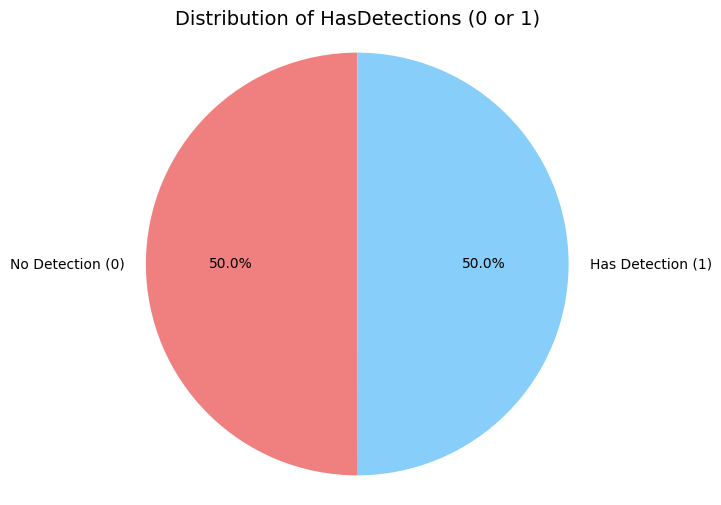

In [16]:
# Create a pie chart
counts = train['HasDetections'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(counts, labels=['No Detection (0)', 'Has Detection (1)'], autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightskyblue'])

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')
plt.title('Distribution of HasDetections (0 or 1)', fontsize=14)

# Show the plot
plt.show()

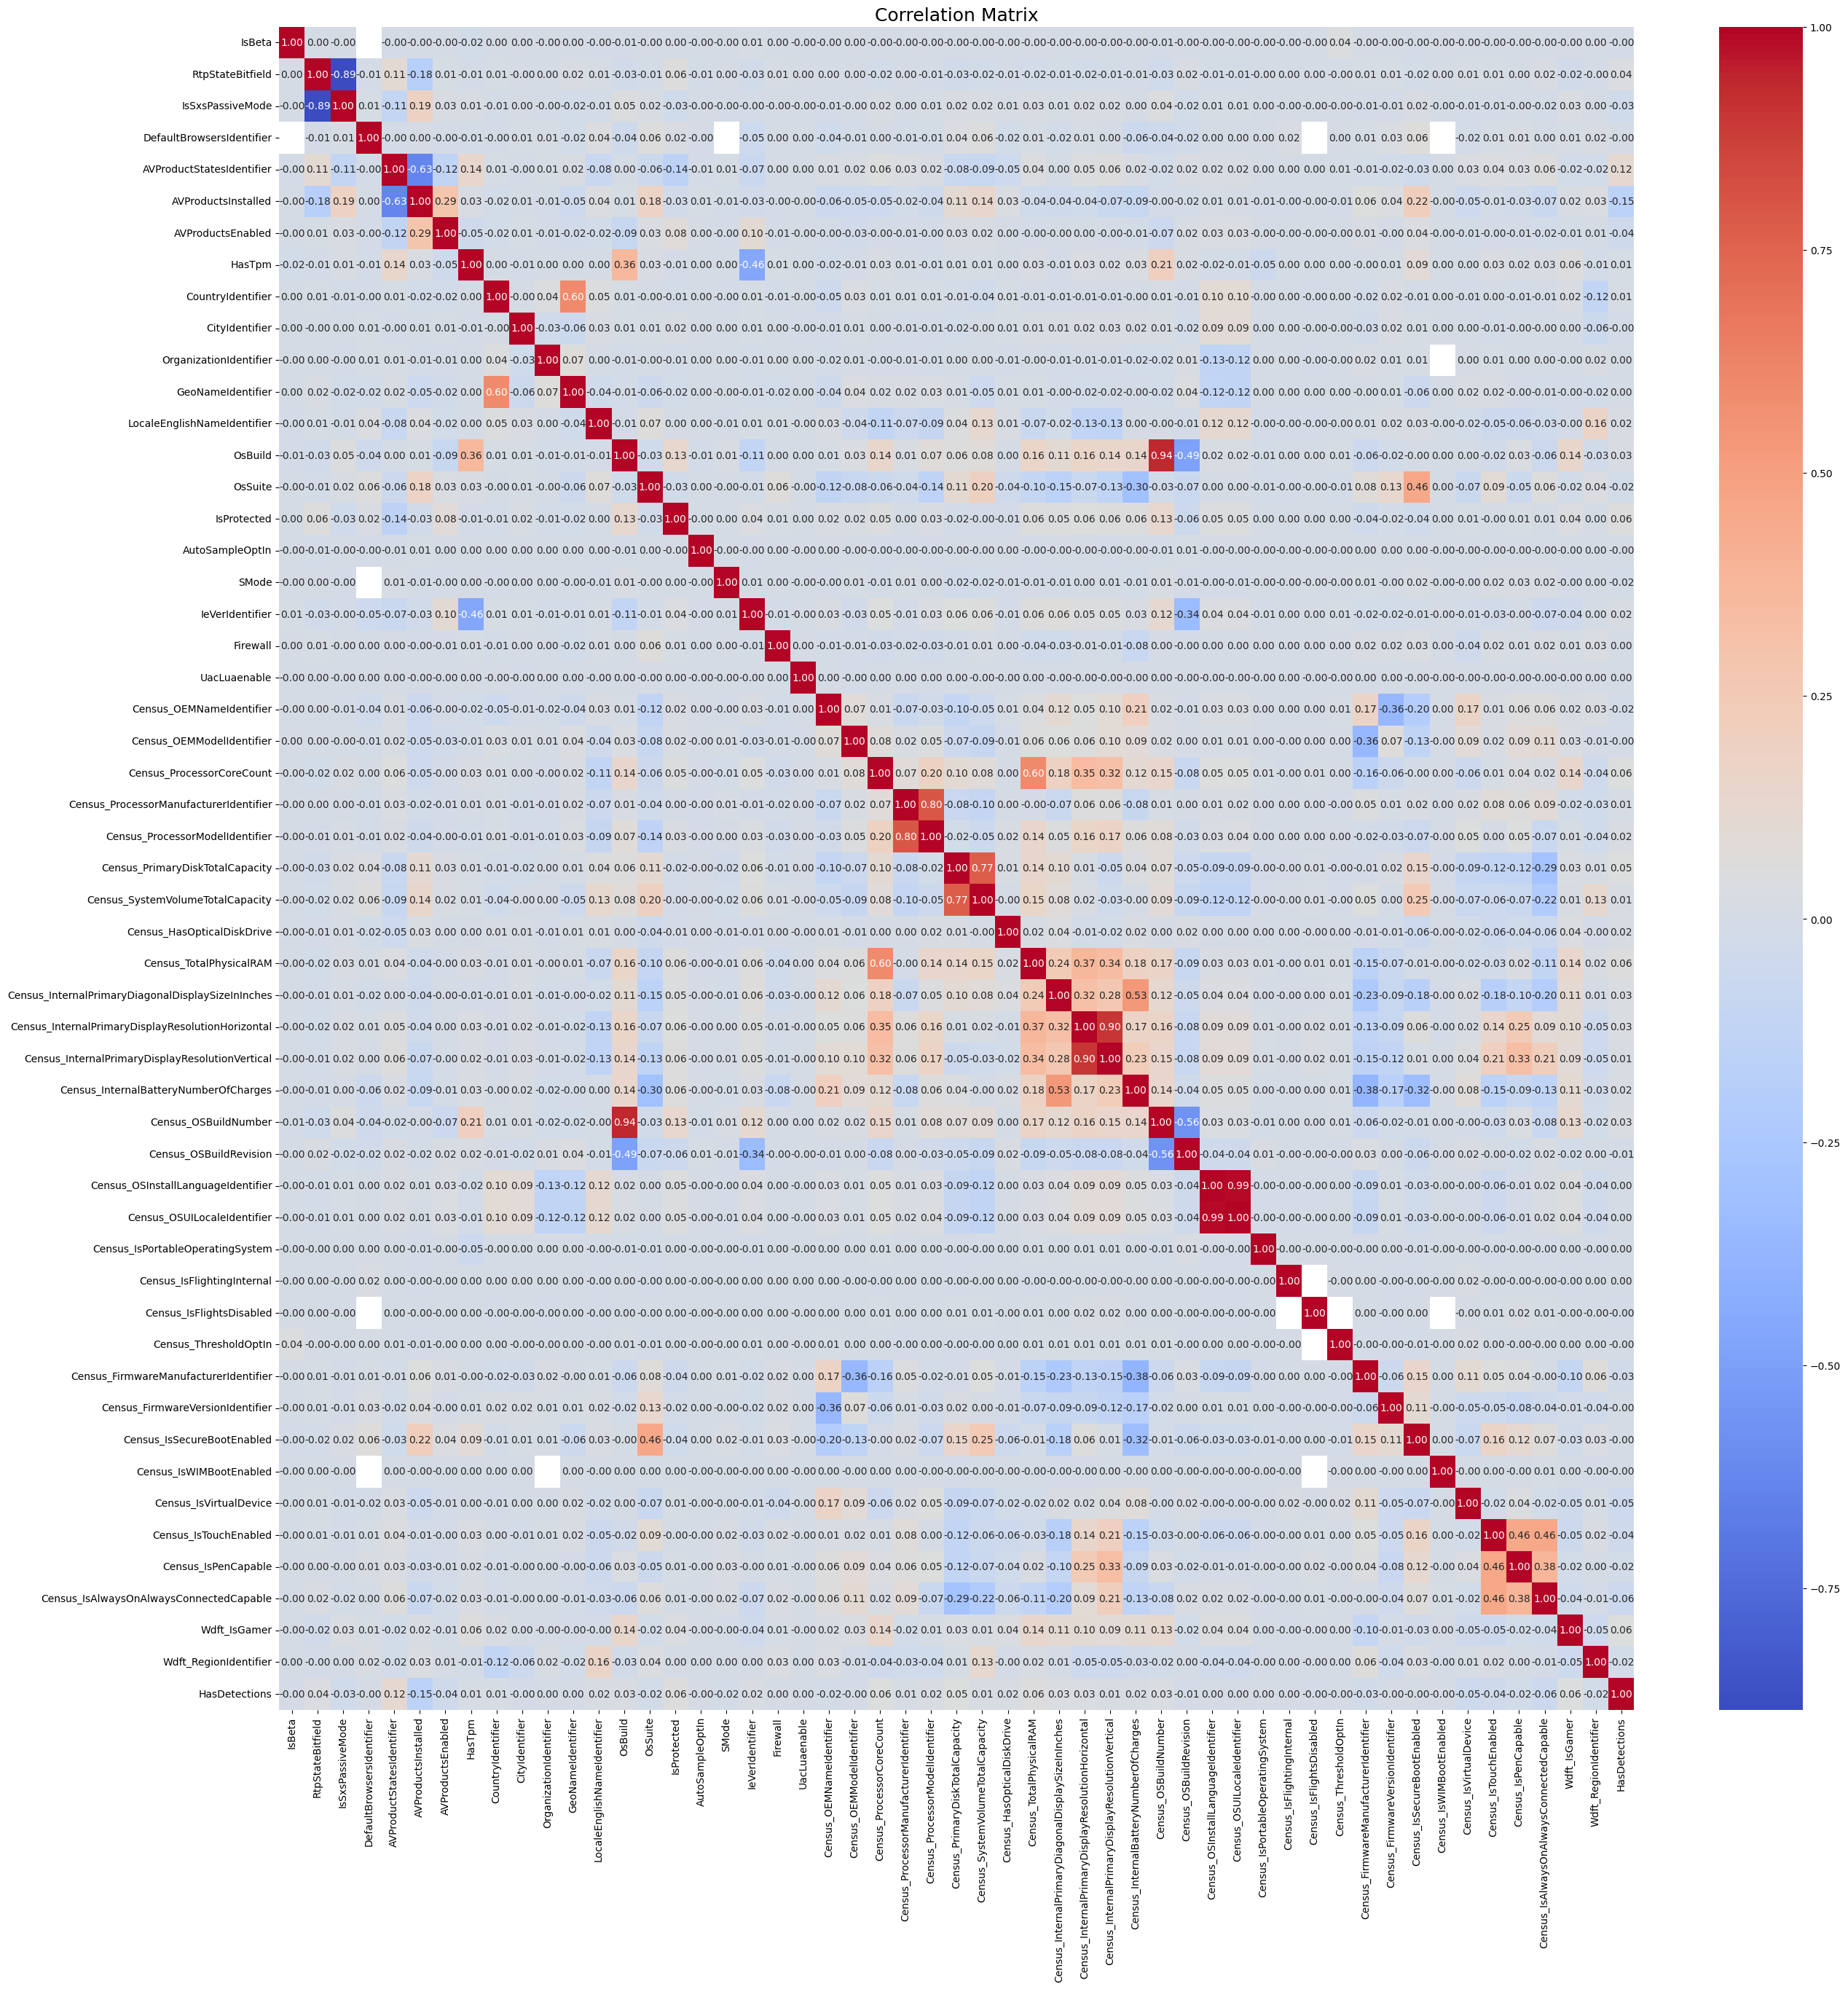

In [17]:

# Calculate the correlation matrix only for numerical columns
corr_matrix = train.select_dtypes(include=['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']).corr()

# Plot the heatmap
plt.figure(figsize=(30, 30))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')

# Add title
plt.title("Correlation Matrix", fontsize=18)

# Save the plot
plt.savefig('/kaggle/working/correlation_matrix.png', bbox_inches='tight')  # Saving to the working directory
# plt.close()  # Close the plot to avoid it displaying twice in the notebook

# print("Plot saved as /kaggle/working/correlation_matrix.png")


In [18]:
# Calculate the correlation matrix for numerical columns
corr_matrix = train.select_dtypes(include=['number']).corr()

# Set a threshold for high correlation (e.g., > 0.8 or < -0.8)
threshold = 0.8

# Create a mask to filter correlations above the threshold or below the negative threshold
high_corr_pairs = []

# Iterate through the correlation matrix to find pairs with high correlation
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

# Create a DataFrame to display the pairs
high_corr_df = pd.DataFrame(high_corr_pairs, columns=['Feature 1', 'Feature 2', 'Correlation'])

# Display the list of highly correlated feature pairs
print(high_corr_df)


                                         Feature 1  \
0                                 IsSxsPassiveMode   
1  Census_InternalPrimaryDisplayResolutionVertical   
2                             Census_OSBuildNumber   
3                      Census_OSUILocaleIdentifier   

                                           Feature 2  Correlation  
0                                   RtpStateBitfield    -0.886036  
1  Census_InternalPrimaryDisplayResolutionHorizontal     0.899880  
2                                            OsBuild     0.937718  
3                 Census_OSInstallLanguageIdentifier     0.988573  


In [19]:
# Calculate skewness and kurtosis for the target variable 'HasDetections'
print("Skewness: %f" % train['HasDetections'].skew())
print("Kurtosis: %f" % train['HasDetections'].kurt())

Skewness: 0.001432
Kurtosis: -2.000002


In [20]:
# Separate numerical and categorical columns
numerical_cols = train.select_dtypes(include=['int64', 'float64', 'int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns.tolist()
categorical_cols = train.select_dtypes(include=['category']).columns.tolist()
#For test dataset
numerical_cols_test = test.select_dtypes(include=['int64', 'float64', 'int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns.tolist()
categorical_cols_test = test.select_dtypes(include=['category']).columns.tolist()
print(f"Total numerical features: {len(numerical_cols)}")
print("Numerical Columns:", numerical_cols)

Total numerical features: 53
Numerical Columns: ['IsBeta', 'RtpStateBitfield', 'IsSxsPassiveMode', 'DefaultBrowsersIdentifier', 'AVProductStatesIdentifier', 'AVProductsInstalled', 'AVProductsEnabled', 'HasTpm', 'CountryIdentifier', 'CityIdentifier', 'OrganizationIdentifier', 'GeoNameIdentifier', 'LocaleEnglishNameIdentifier', 'OsBuild', 'OsSuite', 'IsProtected', 'AutoSampleOptIn', 'SMode', 'IeVerIdentifier', 'Firewall', 'UacLuaenable', 'Census_OEMNameIdentifier', 'Census_OEMModelIdentifier', 'Census_ProcessorCoreCount', 'Census_ProcessorManufacturerIdentifier', 'Census_ProcessorModelIdentifier', 'Census_PrimaryDiskTotalCapacity', 'Census_SystemVolumeTotalCapacity', 'Census_HasOpticalDiskDrive', 'Census_TotalPhysicalRAM', 'Census_InternalPrimaryDiagonalDisplaySizeInInches', 'Census_InternalPrimaryDisplayResolutionHorizontal', 'Census_InternalPrimaryDisplayResolutionVertical', 'Census_InternalBatteryNumberOfCharges', 'Census_OSBuildNumber', 'Census_OSBuildRevision', 'Census_OSInstallLang

In [21]:
print(f"Total Categorical features: {len(categorical_cols)}")
print("Categorical Columns:", categorical_cols)

Total Categorical features: 30
Categorical Columns: ['MachineIdentifier', 'ProductName', 'EngineVersion', 'AppVersion', 'AvSigVersion', 'Platform', 'Processor', 'OsVer', 'OsPlatformSubRelease', 'OsBuildLab', 'SkuEdition', 'PuaMode', 'SmartScreen', 'Census_MDC2FormFactor', 'Census_DeviceFamily', 'Census_ProcessorClass', 'Census_PrimaryDiskTypeName', 'Census_ChassisTypeName', 'Census_PowerPlatformRoleName', 'Census_InternalBatteryType', 'Census_OSVersion', 'Census_OSArchitecture', 'Census_OSBranch', 'Census_OSEdition', 'Census_OSSkuName', 'Census_OSInstallTypeName', 'Census_OSWUAutoUpdateOptionsName', 'Census_GenuineStateName', 'Census_ActivationChannel', 'Census_FlightRing']


In [22]:
# Convert to sets to find differences
numerical_cols_set = set(numerical_cols)
numerical_cols_test_set = set(numerical_cols_test)

# Find the difference in both directions
columns_in_train_not_in_test = numerical_cols_set - numerical_cols_test_set
columns_in_test_not_in_train = numerical_cols_test_set - numerical_cols_set

# Print the differences
print(f"Columns in train dataset but not in test dataset: {columns_in_train_not_in_test}")
print(f"Columns in test dataset but not in train dataset: {columns_in_test_not_in_train}")


Columns in train dataset but not in test dataset: {'HasDetections'}
Columns in test dataset but not in train dataset: set()


# Numerical data

In [23]:
missing_values = train[numerical_cols].isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
print("\nMissing values in numerical features:")
print(missing_values)


Missing values in numerical features:
DefaultBrowsersIdentifier                            951411
Census_IsFlightingInternal                           830277
Census_ThresholdOptIn                                635271
Census_IsWIMBootEnabled                              634418
OrganizationIdentifier                               309160
SMode                                                 60077
CityIdentifier                                        36305
Wdft_RegionIdentifier                                 33981
Wdft_IsGamer                                          33981
Census_InternalBatteryNumberOfCharges                 30160
Census_FirmwareManufacturerIdentifier                 20658
Census_FirmwareVersionIdentifier                      18038
Census_IsFlightsDisabled                              18006
Census_OEMModelIdentifier                             11607
Census_OEMNameIdentifier                              10838
Firewall                                              10304
C

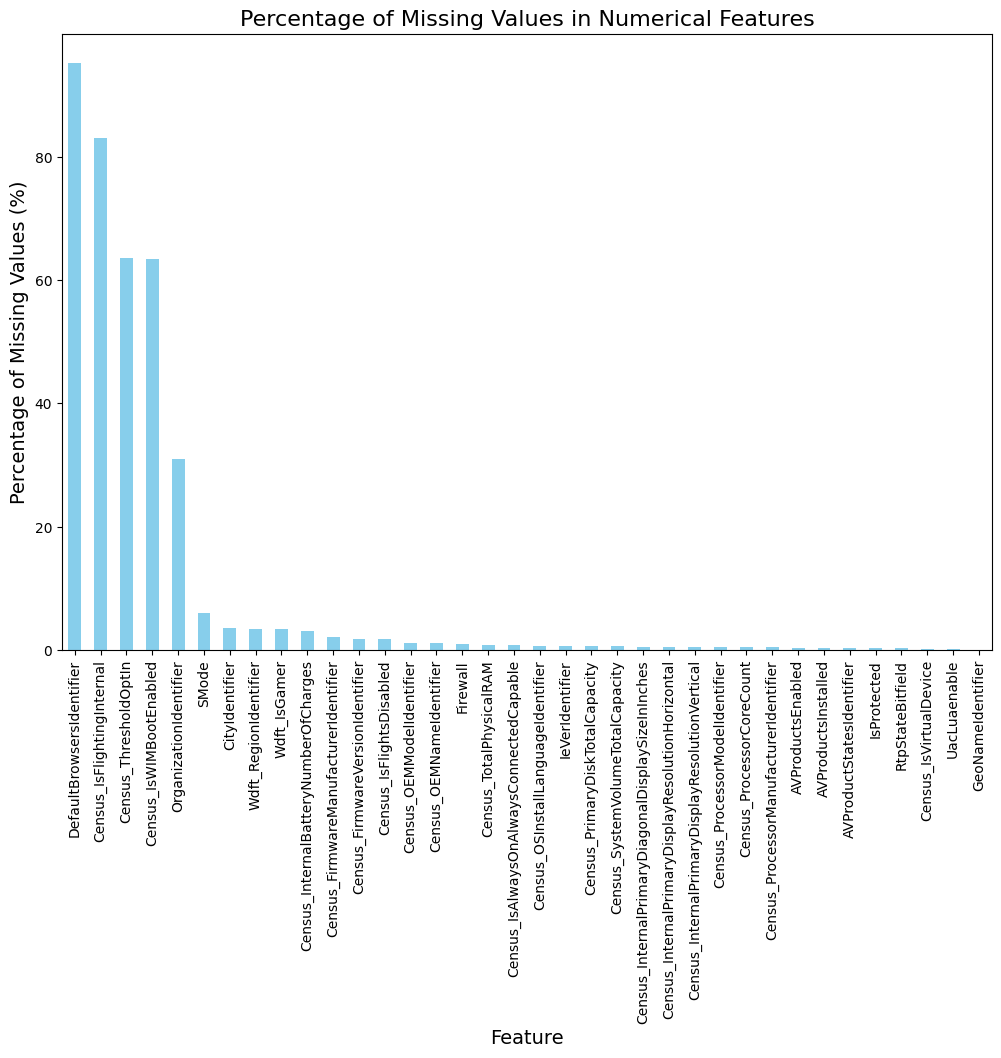

In [24]:
# Calculate the percentage of missing values
missing_percentage = (missing_values / train.shape[0]) * 100

# Create a bar chart for missing data percentages
plt.figure(figsize=(12, 8))
missing_percentage.sort_values(ascending=False).plot(kind='bar', color='skyblue')

# Add titles and labels
plt.title('Percentage of Missing Values in Numerical Features', fontsize=16)
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Percentage of Missing Values (%)', fontsize=14)
plt.xticks(rotation=90)
plt.show()


In [25]:
# Calculate the percentage of missing values for each column
missing_percentage = (missing_values / train.shape[0]) * 100

# Convert the series to a DataFrame for easier viewing
missing_percentage_df = pd.DataFrame({
    'Feature': missing_percentage.index,
    'Missing Percentage': missing_percentage.values
})

# Sort the dataframe by the missing percentage
missing_percentage_df = missing_percentage_df.sort_values(by='Missing Percentage', ascending=False)

# Display the missing percentage in a more readable format
print("Missing Data Percentage per Feature:")
print(missing_percentage_df)


Missing Data Percentage per Feature:
                                              Feature  Missing Percentage
0                           DefaultBrowsersIdentifier             95.1411
1                          Census_IsFlightingInternal             83.0277
2                               Census_ThresholdOptIn             63.5271
3                             Census_IsWIMBootEnabled             63.4418
4                              OrganizationIdentifier             30.9160
5                                               SMode              6.0077
6                                      CityIdentifier              3.6305
7                               Wdft_RegionIdentifier              3.3981
8                                        Wdft_IsGamer              3.3981
9               Census_InternalBatteryNumberOfCharges              3.0160
10              Census_FirmwareManufacturerIdentifier              2.0658
11                   Census_FirmwareVersionIdentifier              1.8038
1

In [26]:
def identify_missing_columns_by_threshold(train, threshold=0.5):
    num_rows = train.shape[0]
    missing_values = train.isnull().sum()
    high_missing_columns = missing_values[missing_values > threshold * num_rows].index.tolist()
    low_missing_columns = missing_values[missing_values <= threshold * num_rows].index.tolist()
    return high_missing_columns, low_missing_columns


In [27]:
# Get the high and low missing columns
high_missing_columns, low_missing_columns = identify_missing_columns_by_threshold(train[numerical_cols])

In [28]:
# Display the results with their lengths
print(f"Columns with more than 50% missing values ({len(high_missing_columns)} columns):")
print(high_missing_columns)

print(f"\nColumns with less than or equal to 50% missing values ({len(low_missing_columns)} columns):")
print(low_missing_columns)

Columns with more than 50% missing values (4 columns):
['DefaultBrowsersIdentifier', 'Census_IsFlightingInternal', 'Census_ThresholdOptIn', 'Census_IsWIMBootEnabled']

Columns with less than or equal to 50% missing values (49 columns):
['IsBeta', 'RtpStateBitfield', 'IsSxsPassiveMode', 'AVProductStatesIdentifier', 'AVProductsInstalled', 'AVProductsEnabled', 'HasTpm', 'CountryIdentifier', 'CityIdentifier', 'OrganizationIdentifier', 'GeoNameIdentifier', 'LocaleEnglishNameIdentifier', 'OsBuild', 'OsSuite', 'IsProtected', 'AutoSampleOptIn', 'SMode', 'IeVerIdentifier', 'Firewall', 'UacLuaenable', 'Census_OEMNameIdentifier', 'Census_OEMModelIdentifier', 'Census_ProcessorCoreCount', 'Census_ProcessorManufacturerIdentifier', 'Census_ProcessorModelIdentifier', 'Census_PrimaryDiskTotalCapacity', 'Census_SystemVolumeTotalCapacity', 'Census_HasOpticalDiskDrive', 'Census_TotalPhysicalRAM', 'Census_InternalPrimaryDiagonalDisplaySizeInInches', 'Census_InternalPrimaryDisplayResolutionHorizontal', 'Cen

In [29]:
train.drop(columns=['DefaultBrowsersIdentifier', 'Census_IsFlightingInternal', 'Census_ThresholdOptIn', 'Census_IsWIMBootEnabled'], inplace=True)
test.drop(columns=['DefaultBrowsersIdentifier', 'Census_IsFlightingInternal', 'Census_ThresholdOptIn', 'Census_IsWIMBootEnabled'], inplace=True)

In [30]:
# Ensure numerical columns only include those present in both train and test datasets
numerical_cols_train = train.select_dtypes(include=['int64', 'float64', 'int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns.tolist()
numerical_cols_test = test.select_dtypes(include=['int64', 'float64', 'int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns.tolist()

# Only use common columns between train and test
common_numerical_cols = list(set(numerical_cols_train) & set(numerical_cols_test))

# Check which columns have missing values in the training set
missing_columns = train[common_numerical_cols].isnull().sum()
missing_columns = missing_columns[missing_columns > 0]

# Impute with mean
from sklearn.impute import SimpleImputer

# Create an imputer object to replace missing values with the mean
imputer = SimpleImputer(strategy='mean')

# Apply the imputer to the training set
train[common_numerical_cols] = imputer.fit_transform(train[common_numerical_cols])

# Apply the same imputer to the test set
test[common_numerical_cols] = imputer.transform(test[common_numerical_cols])

# Verify that the missing values have been handled
print(f"Missing values in train set after imputation:\n{train[common_numerical_cols].isnull().sum()}")
print(f"\nMissing values in test set after imputation:\n{test[common_numerical_cols].isnull().sum()}")


Missing values in train set after imputation:
Census_TotalPhysicalRAM                              0
Census_InternalBatteryNumberOfCharges                0
Census_OSUILocaleIdentifier                          0
Census_IsFlightsDisabled                             0
UacLuaenable                                         0
Census_OSBuildRevision                               0
Census_OEMNameIdentifier                             0
Census_IsVirtualDevice                               0
IeVerIdentifier                                      0
Census_IsAlwaysOnAlwaysConnectedCapable              0
Census_HasOpticalDiskDrive                           0
OrganizationIdentifier                               0
Census_IsPortableOperatingSystem                     0
Census_SystemVolumeTotalCapacity                     0
OsSuite                                              0
Census_InternalPrimaryDisplayResolutionHorizontal    0
Census_InternalPrimaryDisplayResolutionVertical      0
Census_IsPenCapable

In [31]:

# Create a scaler object
scaler = StandardScaler()

# Fit and transform the train data
train[common_numerical_cols] = scaler.fit_transform(train[common_numerical_cols])

# Transform the test data
test[common_numerical_cols] = scaler.transform(test[common_numerical_cols])

# Get descriptive statistics for both train and test data after scaling
train_desc = train[common_numerical_cols].describe().T
test_desc = test[common_numerical_cols].describe().T

# Print the statistics in a more readable format
print("Train Data After Scaling:")
print(train_desc[['mean', 'std', 'min', '25%', '50%', '75%', 'max']].round(2))

print("\nTest Data After Scaling:")
print(test_desc[['mean', 'std', 'min', '25%', '50%', '75%', 'max']].round(2))


Train Data After Scaling:
                                                   mean  std   min   25%  \
Census_TotalPhysicalRAM                            -0.0  1.0 -1.16 -0.40   
Census_InternalBatteryNumberOfCharges               0.0  1.0 -0.60 -0.60   
Census_OSUILocaleIdentifier                         0.0  1.0 -1.32 -0.65   
Census_IsFlightsDisabled                            0.0  1.0 -0.00 -0.00   
UacLuaenable                                        0.0  1.0 -0.00 -0.00   
Census_OSBuildRevision                             -0.0  1.0 -0.33 -0.27   
Census_OEMNameIdentifier                            0.0  1.0 -1.68 -0.59   
Census_IsVirtualDevice                              0.0  1.0 -0.08 -0.08   
IeVerIdentifier                                    -0.0  1.0 -2.79 -0.37   
Census_IsAlwaysOnAlwaysConnectedCapable             0.0  1.0 -0.25 -0.25   
Census_HasOpticalDiskDrive                          0.0  1.0 -0.29 -0.29   
OrganizationIdentifier                              0.0  1.0 -

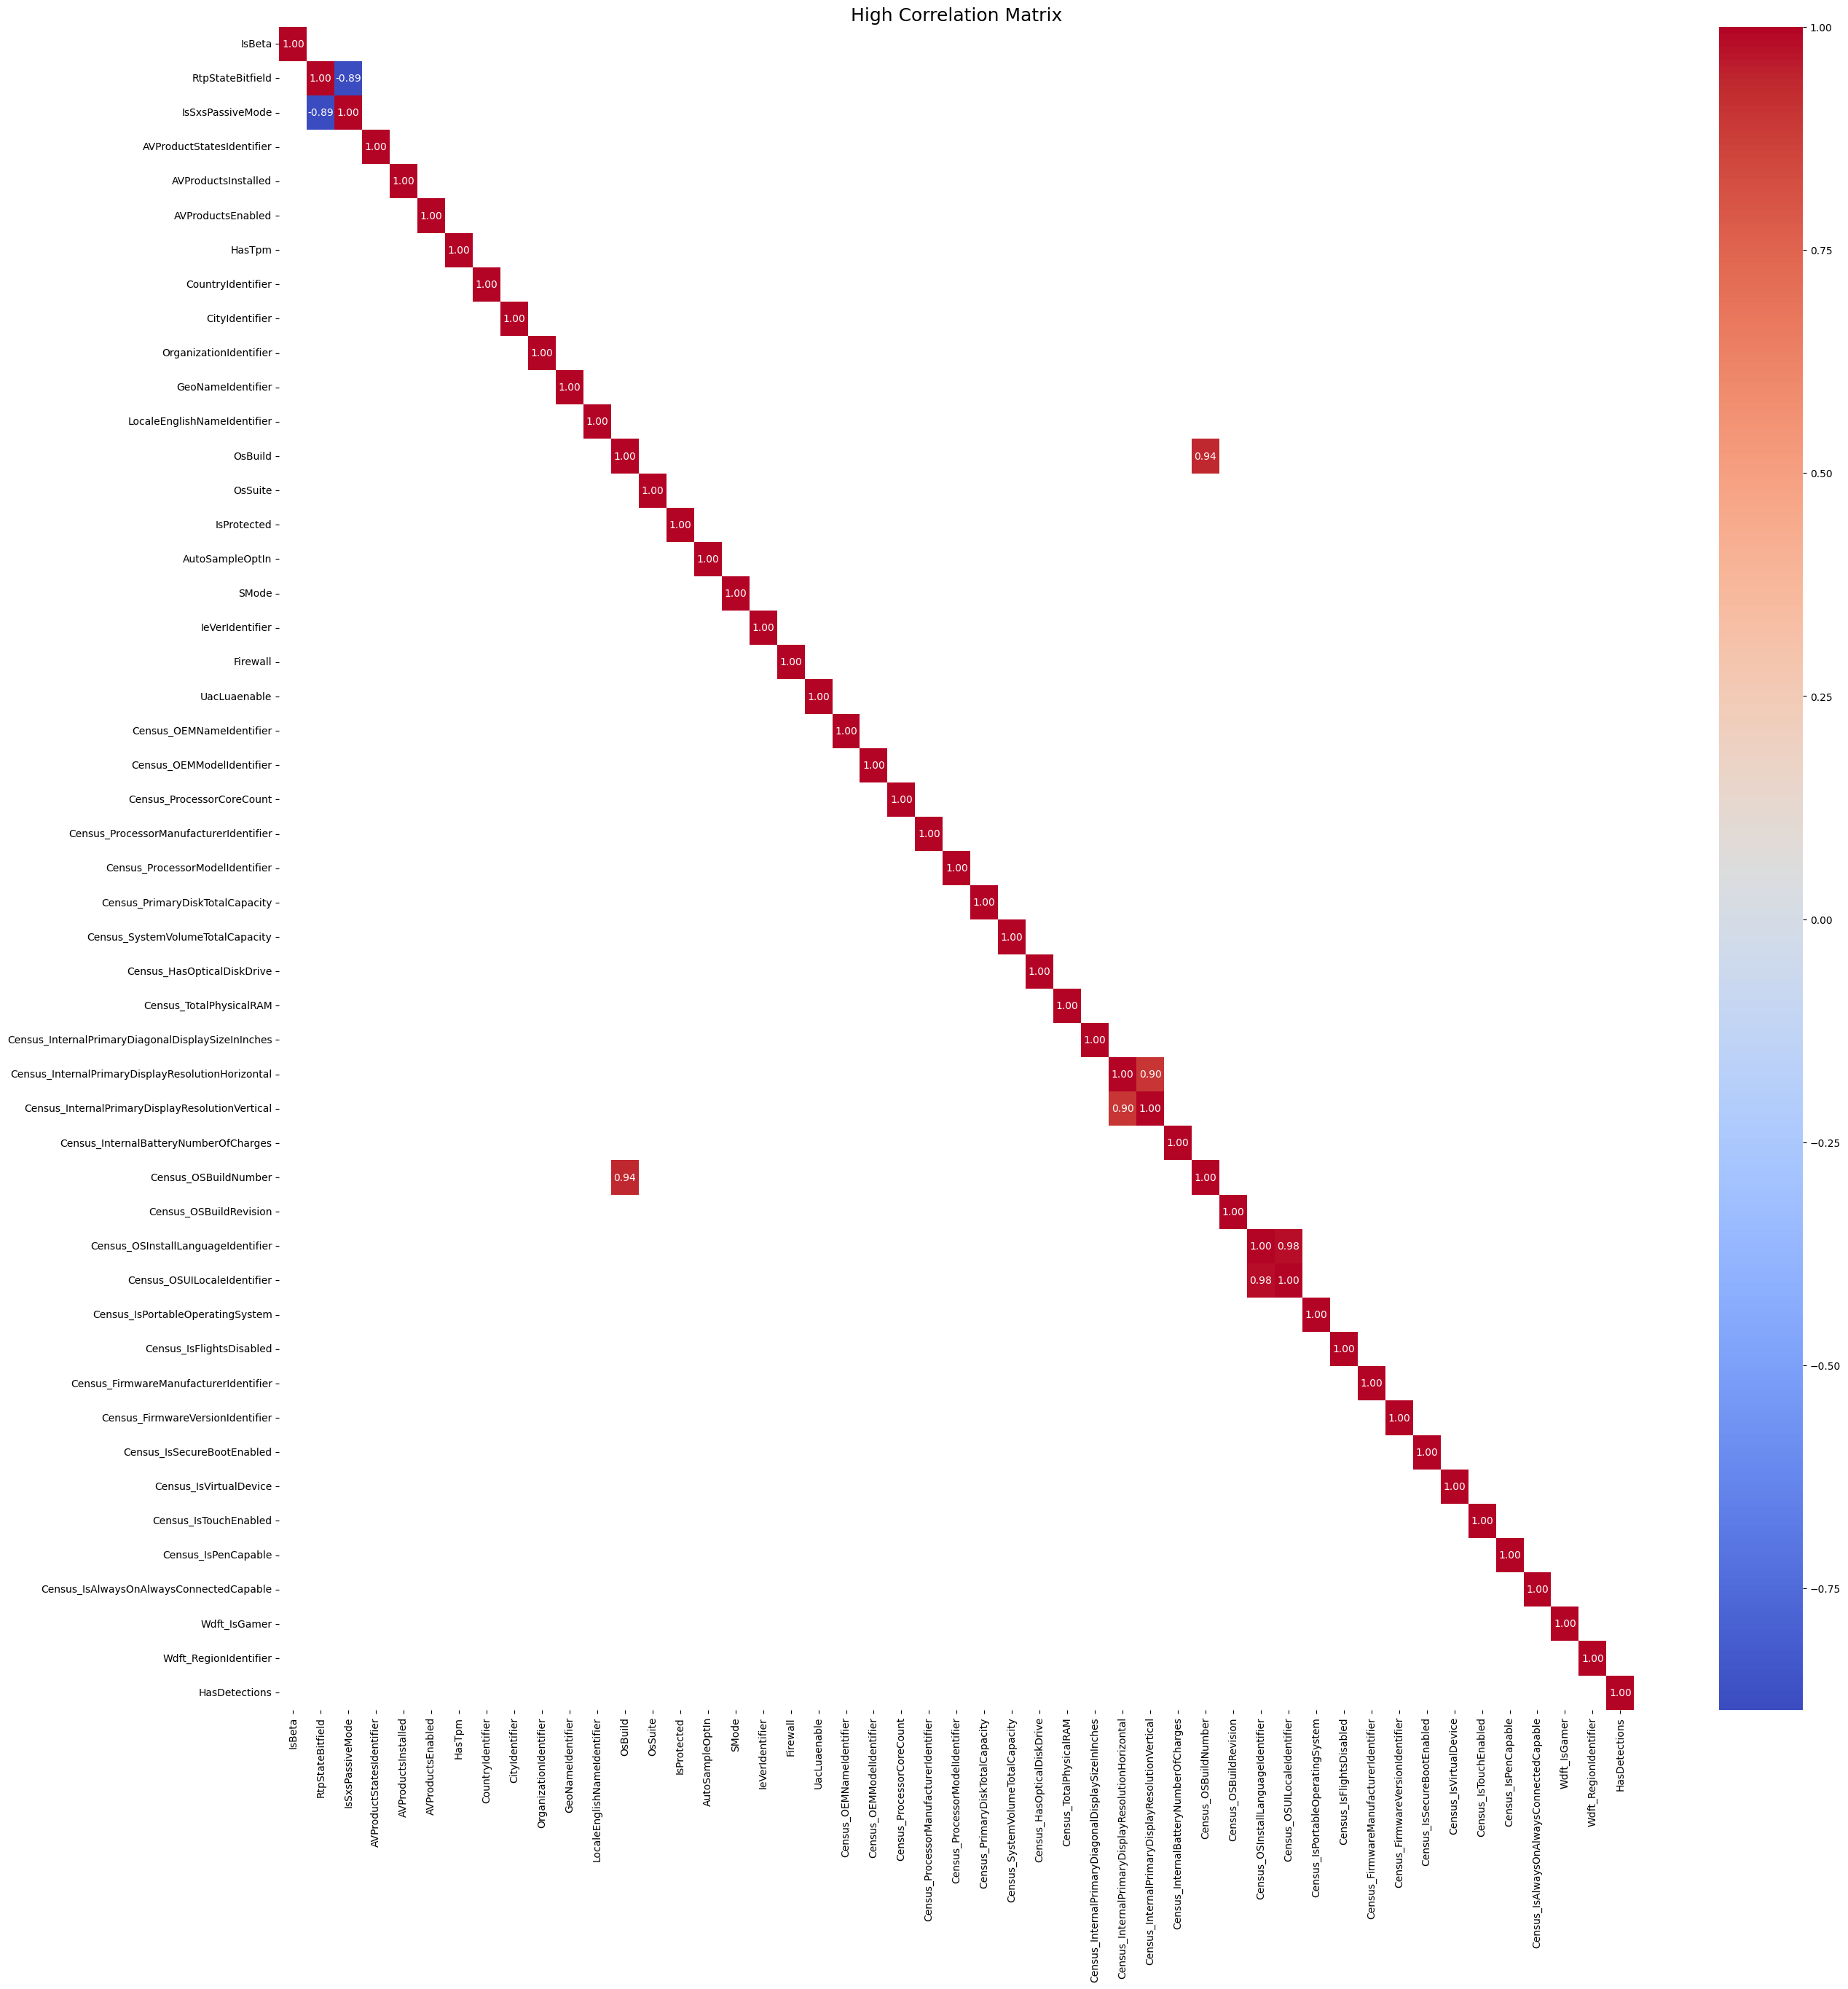

In [32]:
# Calculate the correlation matrix for numerical columns
corr_matrix = train.select_dtypes(include=['number']).corr()

# Set a threshold for high correlation (e.g., > 0.8 or < -0.8)
threshold = 0.8
high_corr_matrix = corr_matrix[(corr_matrix > threshold) | (corr_matrix < -threshold)]

# Plot and save the heatmap
plt.figure(figsize=(30, 30))
sns.heatmap(high_corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', mask=high_corr_matrix.isna())
plt.title("High Correlation Matrix", fontsize=18)
plt.savefig('high_correlation_matrix.png', bbox_inches='tight')  # Save the heatmap
plt.show()


In [33]:
# Calculate the correlation matrix for numerical columns
corr_matrix = train.select_dtypes(include=['number']).corr()

# Set a threshold for high correlation (e.g., > 0.8 or < -0.8)
threshold = 0.8

# Create a mask to filter correlations above the threshold or below the negative threshold
high_corr_pairs = []

# Iterate through the correlation matrix to find pairs with high correlation
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

# Create a DataFrame to display the pairs
high_corr_df = pd.DataFrame(high_corr_pairs, columns=['Feature 1', 'Feature 2', 'Correlation'])

# Display the list of highly correlated feature pairs
print(high_corr_df)


                                         Feature 1  \
0                                 IsSxsPassiveMode   
1  Census_InternalPrimaryDisplayResolutionVertical   
2                             Census_OSBuildNumber   
3                      Census_OSUILocaleIdentifier   

                                           Feature 2  Correlation  
0                                   RtpStateBitfield    -0.885856  
1  Census_InternalPrimaryDisplayResolutionHorizontal     0.899880  
2                                            OsBuild     0.937718  
3                 Census_OSInstallLanguageIdentifier     0.984998  


In [34]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=0.95)  # Keep enough components to explain 95% of the variance
train_pca = pca.fit_transform(train[common_numerical_cols])
test_pca = pca.transform(test[common_numerical_cols])

explained_variance = pca.explained_variance_ratio_

print(f"Explained Variance by each principal component: {explained_variance}")


Explained Variance by each principal component: [0.07462806 0.05749802 0.05112303 0.04518928 0.0432801  0.03989927
 0.03813534 0.03516587 0.03341514 0.03060282 0.03018233 0.02529986
 0.0229626  0.02177458 0.02171028 0.02101885 0.02085845 0.02083589
 0.02082754 0.02081963 0.02079864 0.02073875 0.02062827 0.02029286
 0.01999575 0.01963028 0.01920695 0.0183932  0.01786719 0.01610794
 0.01512699 0.0139787  0.01241182 0.01068141 0.01025843 0.00982842
 0.0094461 ]


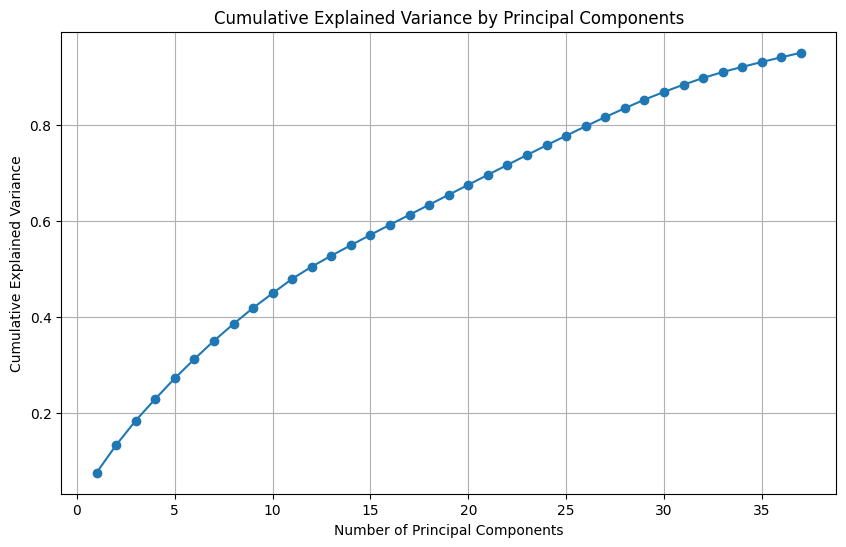

In [35]:
cumulative_variance = explained_variance.cumsum()
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

In [36]:
print(f"Number of components selected: {pca.n_components_}")

Number of components selected: 37


# Categorical

In [37]:
print(f"Total Categorical features: {len(categorical_cols)}")
print("Categorical Columns:", categorical_cols)

Total Categorical features: 30
Categorical Columns: ['MachineIdentifier', 'ProductName', 'EngineVersion', 'AppVersion', 'AvSigVersion', 'Platform', 'Processor', 'OsVer', 'OsPlatformSubRelease', 'OsBuildLab', 'SkuEdition', 'PuaMode', 'SmartScreen', 'Census_MDC2FormFactor', 'Census_DeviceFamily', 'Census_ProcessorClass', 'Census_PrimaryDiskTypeName', 'Census_ChassisTypeName', 'Census_PowerPlatformRoleName', 'Census_InternalBatteryType', 'Census_OSVersion', 'Census_OSArchitecture', 'Census_OSBranch', 'Census_OSEdition', 'Census_OSSkuName', 'Census_OSInstallTypeName', 'Census_OSWUAutoUpdateOptionsName', 'Census_GenuineStateName', 'Census_ActivationChannel', 'Census_FlightRing']


In [38]:
# Get the high and low missing columns
high_missing_columns, low_missing_columns = identify_missing_columns_by_threshold(train[categorical_cols])
# Display the results with their lengths
print(f"Columns with more than 50% missing values ({len(high_missing_columns)} columns):")
print(high_missing_columns)

Columns with more than 50% missing values (3 columns):
['PuaMode', 'Census_ProcessorClass', 'Census_InternalBatteryType']


In [39]:
print(f"\nColumns with less than or equal to 50% missing values ({len(low_missing_columns)} columns):")
print(low_missing_columns)


Columns with less than or equal to 50% missing values (27 columns):
['MachineIdentifier', 'ProductName', 'EngineVersion', 'AppVersion', 'AvSigVersion', 'Platform', 'Processor', 'OsVer', 'OsPlatformSubRelease', 'OsBuildLab', 'SkuEdition', 'SmartScreen', 'Census_MDC2FormFactor', 'Census_DeviceFamily', 'Census_PrimaryDiskTypeName', 'Census_ChassisTypeName', 'Census_PowerPlatformRoleName', 'Census_OSVersion', 'Census_OSArchitecture', 'Census_OSBranch', 'Census_OSEdition', 'Census_OSSkuName', 'Census_OSInstallTypeName', 'Census_OSWUAutoUpdateOptionsName', 'Census_GenuineStateName', 'Census_ActivationChannel', 'Census_FlightRing']


In [40]:
# Calculate the percentage of missing values for each column
missing_percentage = train[categorical_cols].isnull().mean() * 100  # Percentage of missing values in each column
missing_percentage = missing_percentage.sort_values(ascending=False)  # Sort by descending order

# Display the percentage of missing values
print("Percentage of Missing Values in Each Column:")
print(missing_percentage)

Percentage of Missing Values in Each Column:
PuaMode                             99.9742
Census_ProcessorClass               99.5825
Census_InternalBatteryType          71.0503
SmartScreen                         35.6618
Census_PrimaryDiskTypeName           0.1430
Census_ChassisTypeName               0.0063
Census_PowerPlatformRoleName         0.0006
OsBuildLab                           0.0002
Census_OSInstallTypeName             0.0000
Census_OSSkuName                     0.0000
Census_OSEdition                     0.0000
Census_OSArchitecture                0.0000
Census_OSWUAutoUpdateOptionsName     0.0000
Census_GenuineStateName              0.0000
Census_OSVersion                     0.0000
Census_ActivationChannel             0.0000
Census_OSBranch                      0.0000
MachineIdentifier                    0.0000
ProductName                          0.0000
Census_DeviceFamily                  0.0000
Census_MDC2FormFactor                0.0000
SkuEdition                     

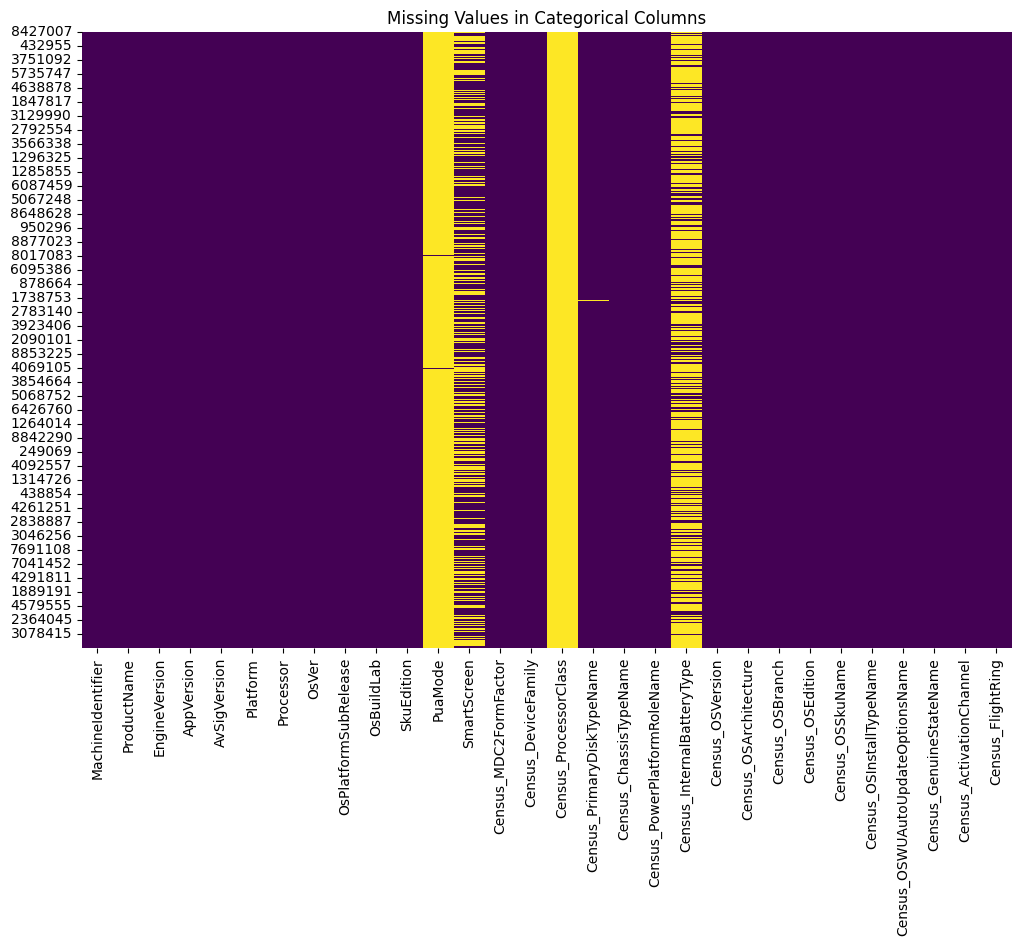

In [41]:
# Visualizing missing values using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(train[categorical_cols].isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values in Categorical Columns')
plt.show()


In [42]:
train.drop(columns=['PuaMode', 'Census_ProcessorClass', 'Census_InternalBatteryType'], inplace=True)
test.drop(columns=['PuaMode', 'Census_ProcessorClass', 'Census_InternalBatteryType'], inplace=True)

In [43]:
categorical_cols = train.select_dtypes(include=['category']).columns.tolist()
#For test dataset
categorical_cols_test = test.select_dtypes(include=['category']).columns.tolist()


In [44]:
# Display distinct values in each categorical column
for col in categorical_cols:
    print(f"\nDistinct values in column '{col}':")
    print(train[col].value_counts())  # You can use value_counts to display frequency of each category
    print(f"Number of distinct values: {len(train[col].unique())}")



Distinct values in column 'MachineIdentifier':
MachineIdentifier
000007905a28d863f6d0d597892cd692    1
aa9f3037a3c02a18083b5987831ece2b    1
aa9f42812c95dc7f9bce3e556d8b6ed1    1
aa9f5591717b87201bef9e484aea6cdb    1
aa9f57c867b25f3573124ced30779268    1
                                   ..
552d8b1b0eb541d18a77fc912e3335dd    1
552dcb8aff432dd3433339b1107063f8    1
552dd8c53fce0524ccc9271a0c65f192    1
552df065fa99baa6181bb3015aecb24a    1
ffffe845668e2b132716cbd523352e76    1
Name: count, Length: 1000000, dtype: int64
Number of distinct values: 1000000

Distinct values in column 'ProductName':
ProductName
win8defender     989220
mse               10772
mseprerelease         6
fep                   1
scep                  1
Name: count, dtype: int64
Number of distinct values: 5

Distinct values in column 'EngineVersion':
EngineVersion
1.1.15200.1    431401
1.1.15100.1    411941
1.1.15000.2     29713
1.1.14901.4     23818
1.1.14600.4     18008
1.1.14800.3     15106
1.1.15300.6     135

In [45]:
train.drop(columns=['MachineIdentifier'], inplace=True)
test.drop(columns=['MachineIdentifier'], inplace=True)

In [46]:
categorical_cols_test = test.select_dtypes(include=['category']).columns.tolist()
categorical_cols = train.select_dtypes(include=['category']).columns.tolist()
print(f"Total Categorical features: {len(categorical_cols)}")
print("Categorical Columns:", categorical_cols)

Total Categorical features: 26
Categorical Columns: ['ProductName', 'EngineVersion', 'AppVersion', 'AvSigVersion', 'Platform', 'Processor', 'OsVer', 'OsPlatformSubRelease', 'OsBuildLab', 'SkuEdition', 'SmartScreen', 'Census_MDC2FormFactor', 'Census_DeviceFamily', 'Census_PrimaryDiskTypeName', 'Census_ChassisTypeName', 'Census_PowerPlatformRoleName', 'Census_OSVersion', 'Census_OSArchitecture', 'Census_OSBranch', 'Census_OSEdition', 'Census_OSSkuName', 'Census_OSInstallTypeName', 'Census_OSWUAutoUpdateOptionsName', 'Census_GenuineStateName', 'Census_ActivationChannel', 'Census_FlightRing']


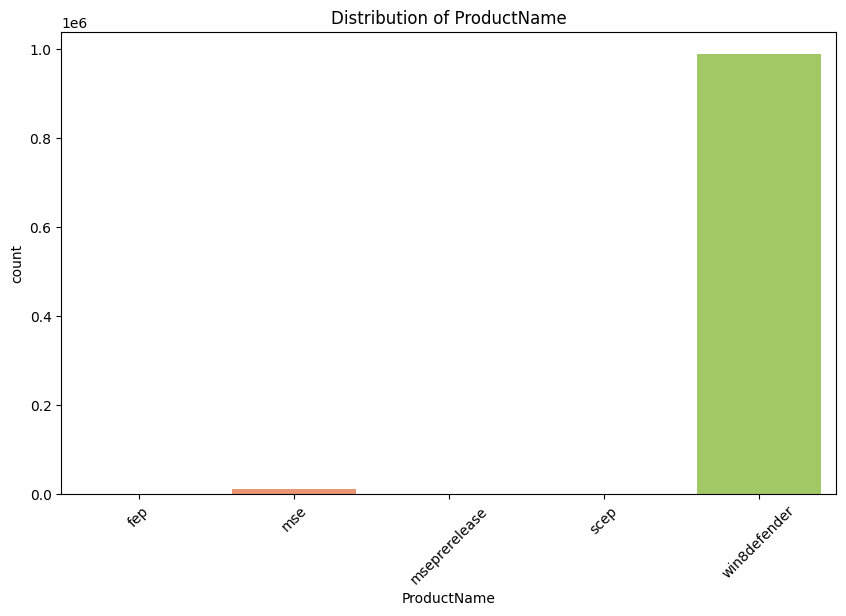

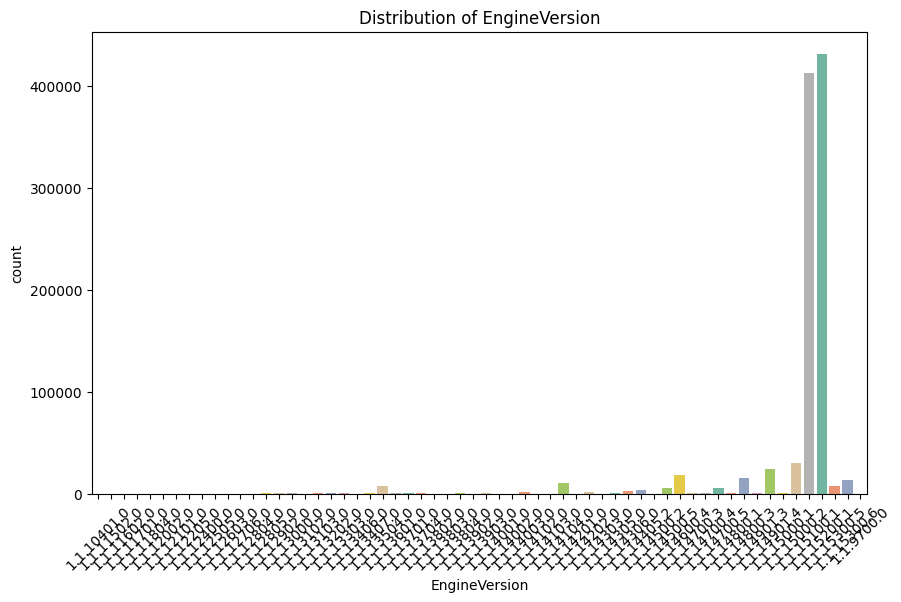

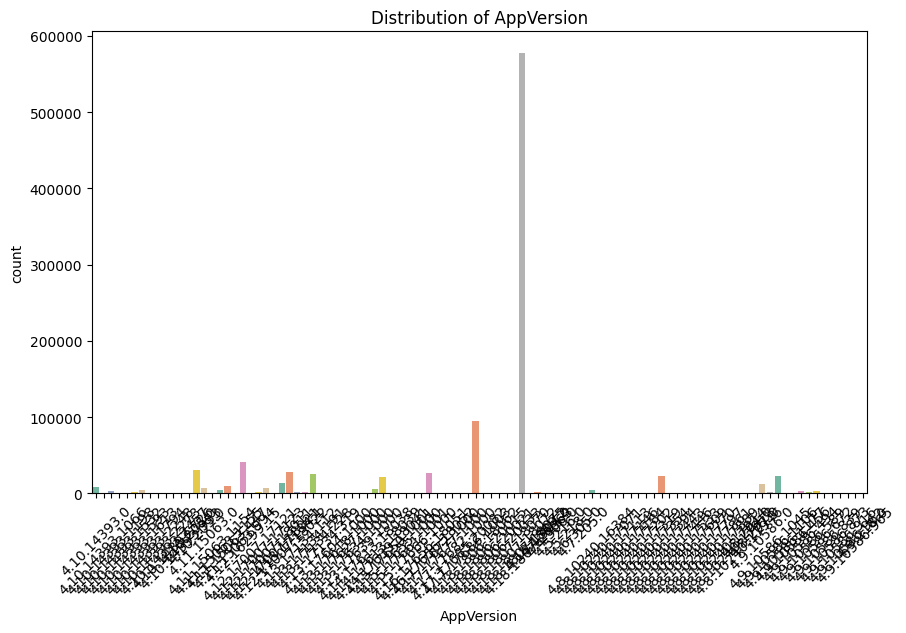

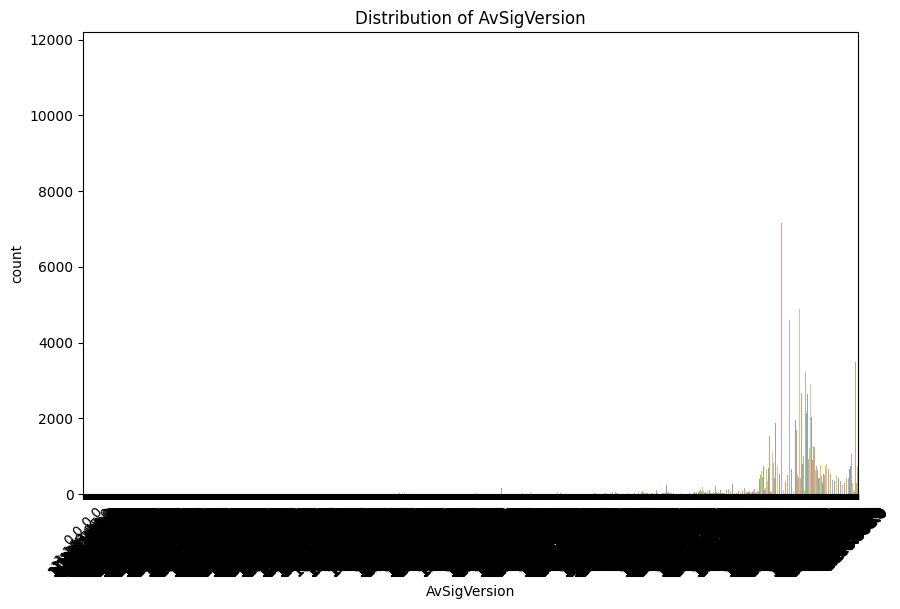

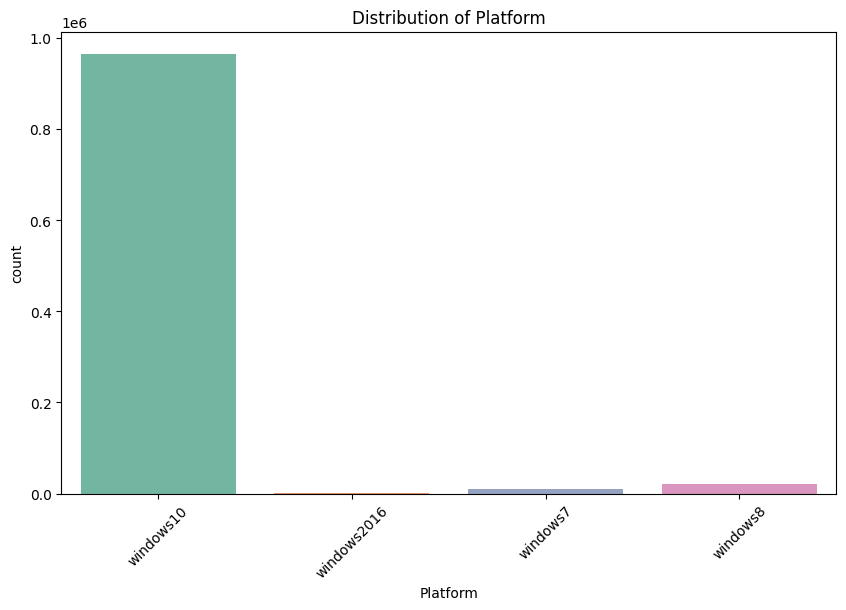

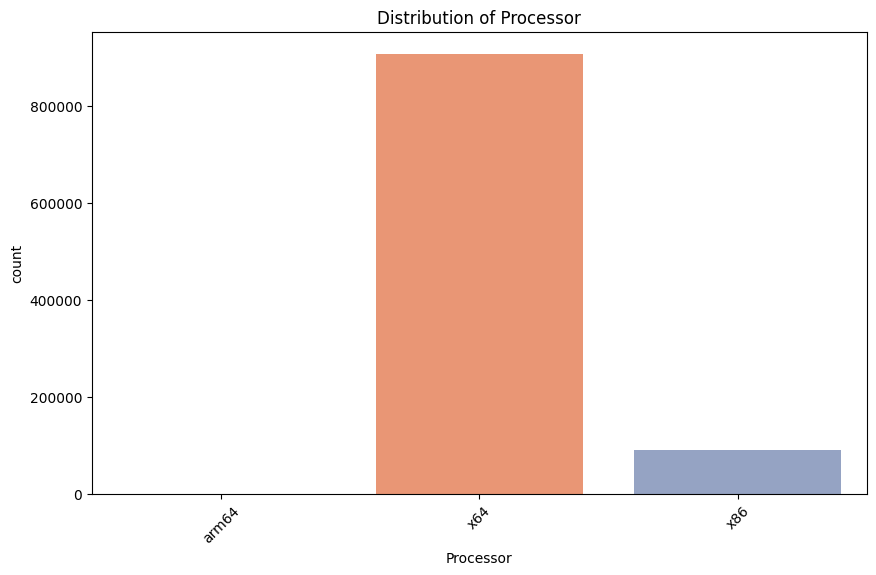

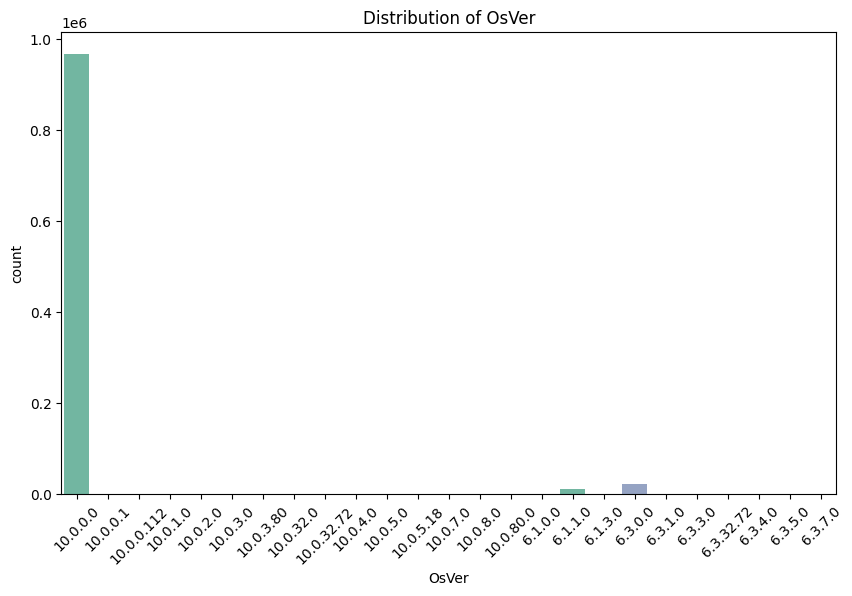

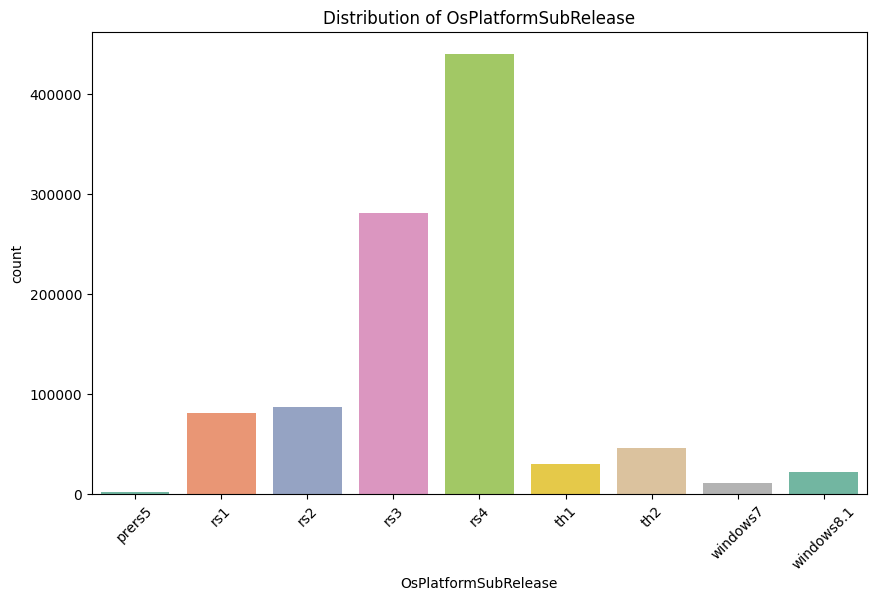

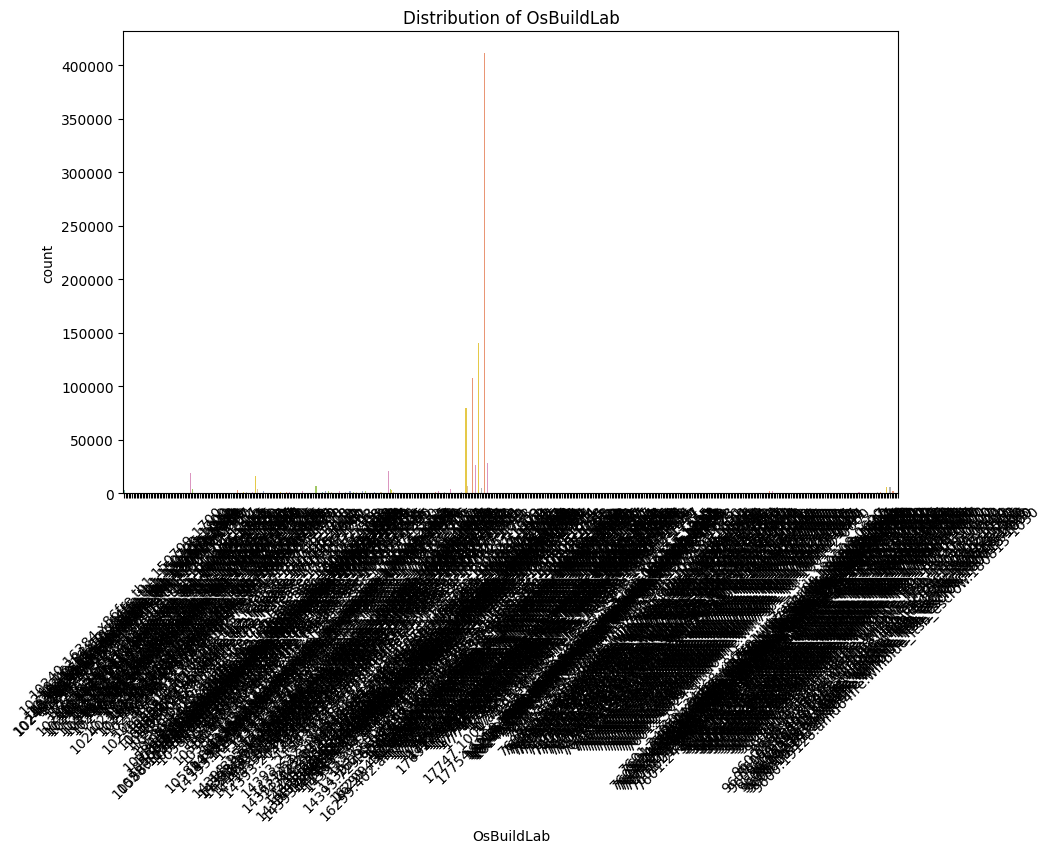

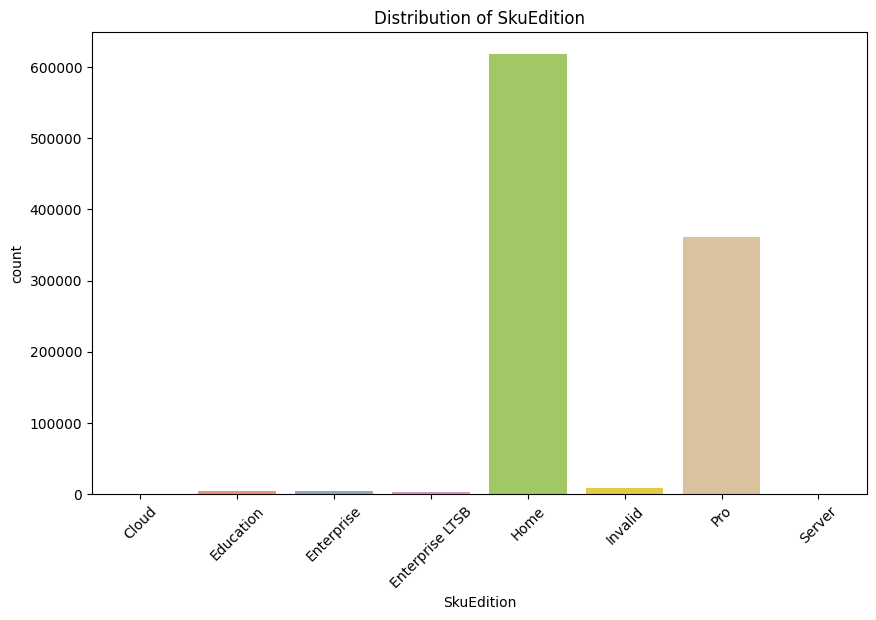

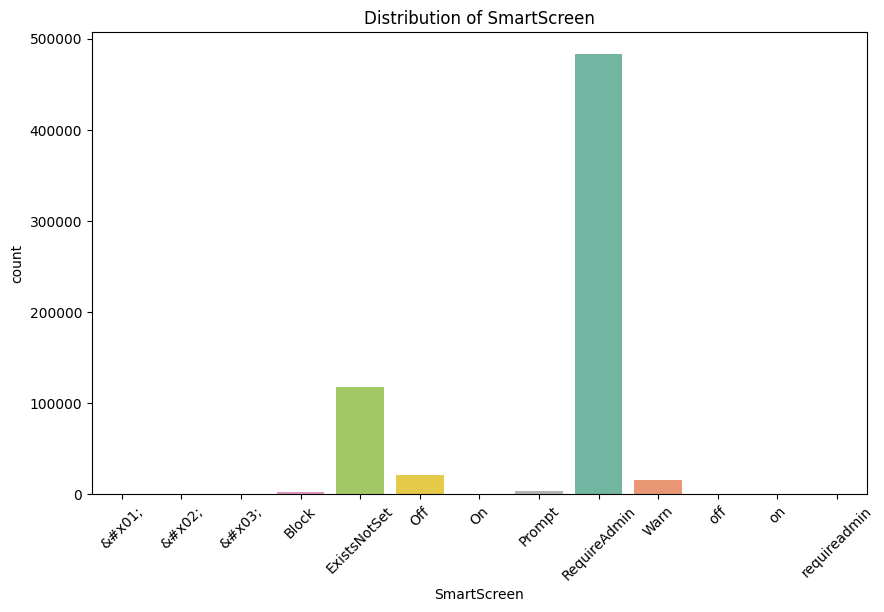

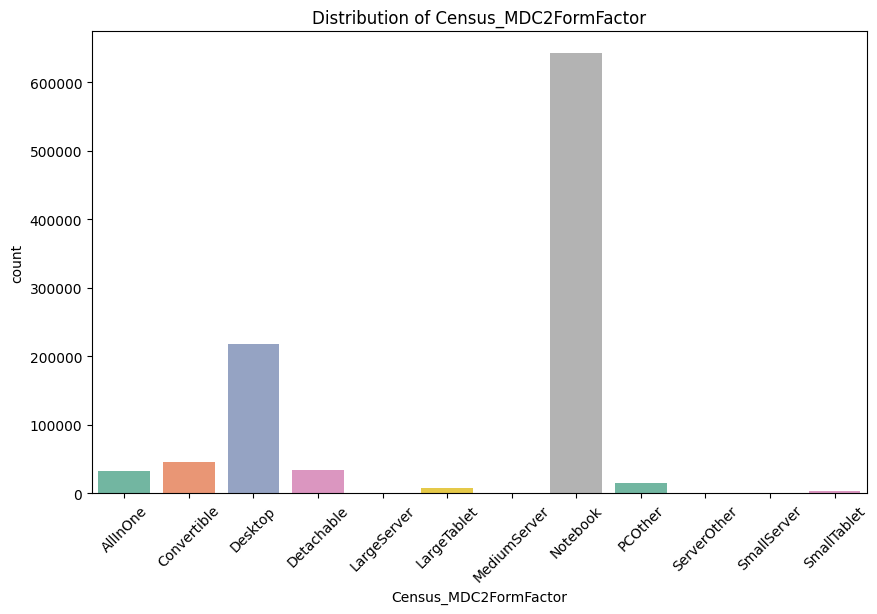

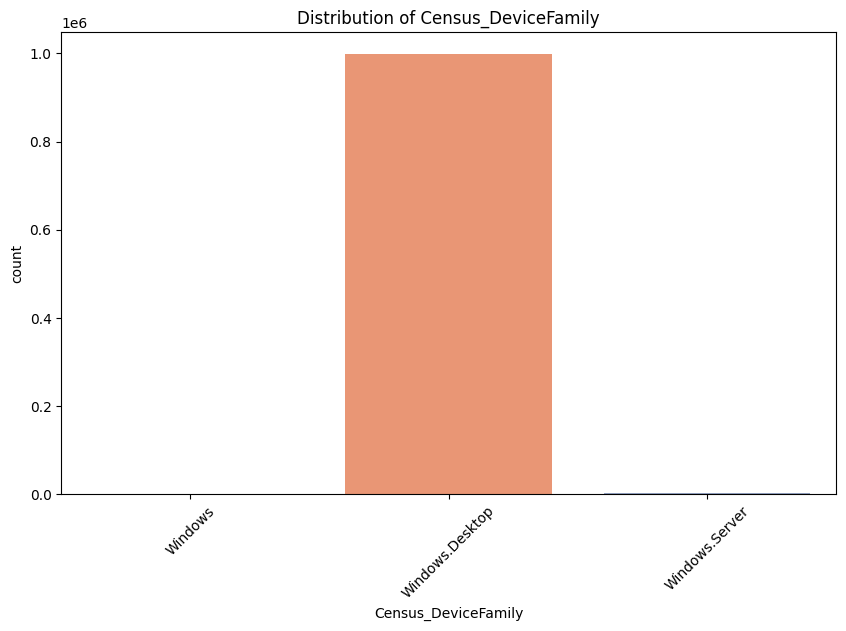

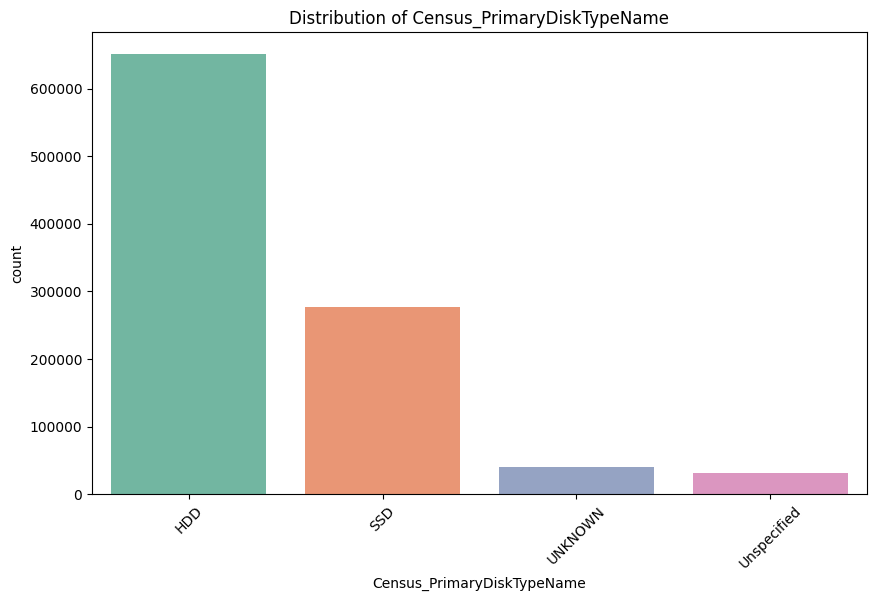

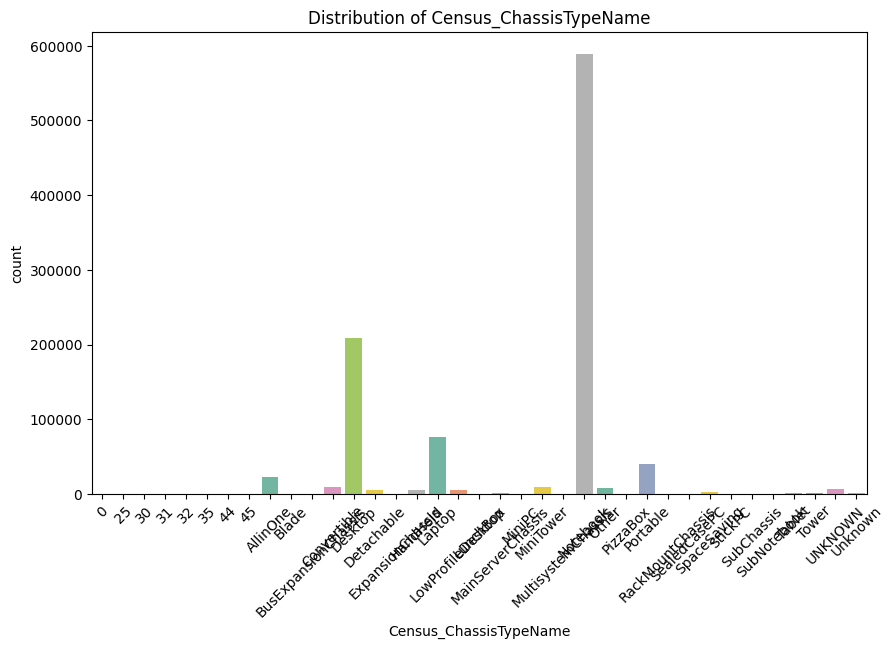

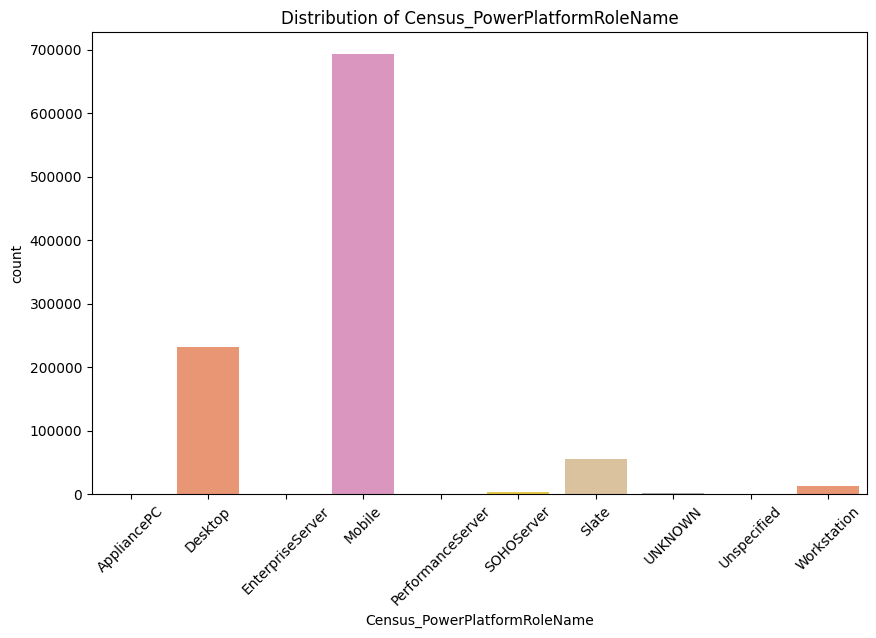

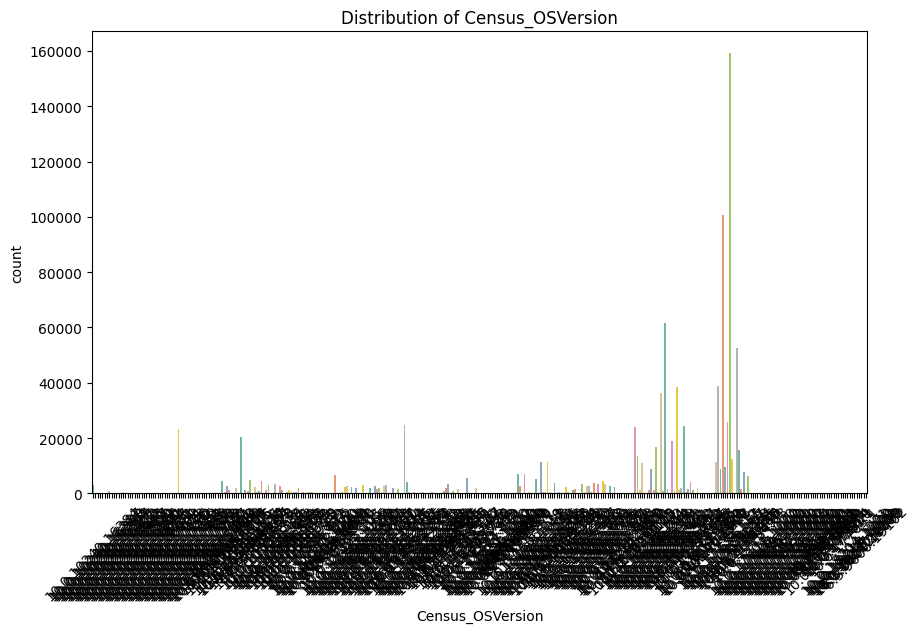

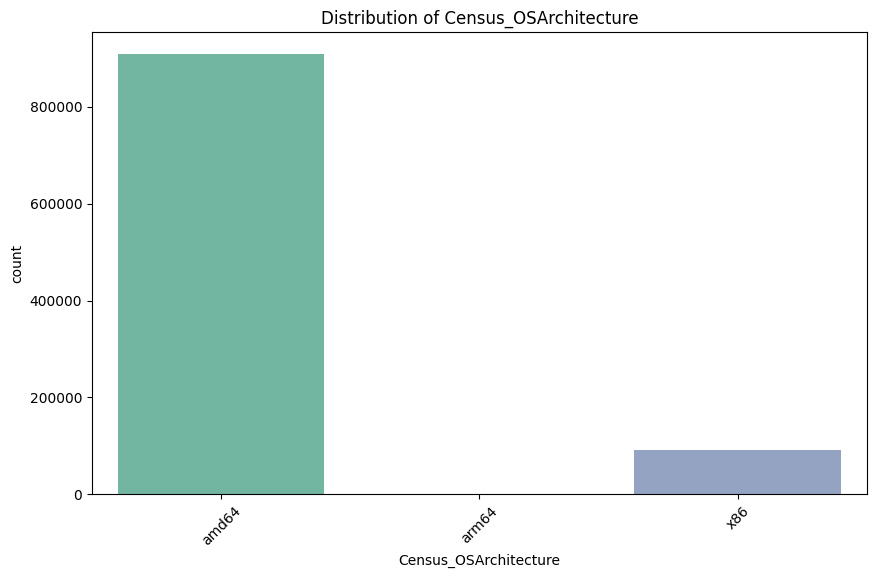

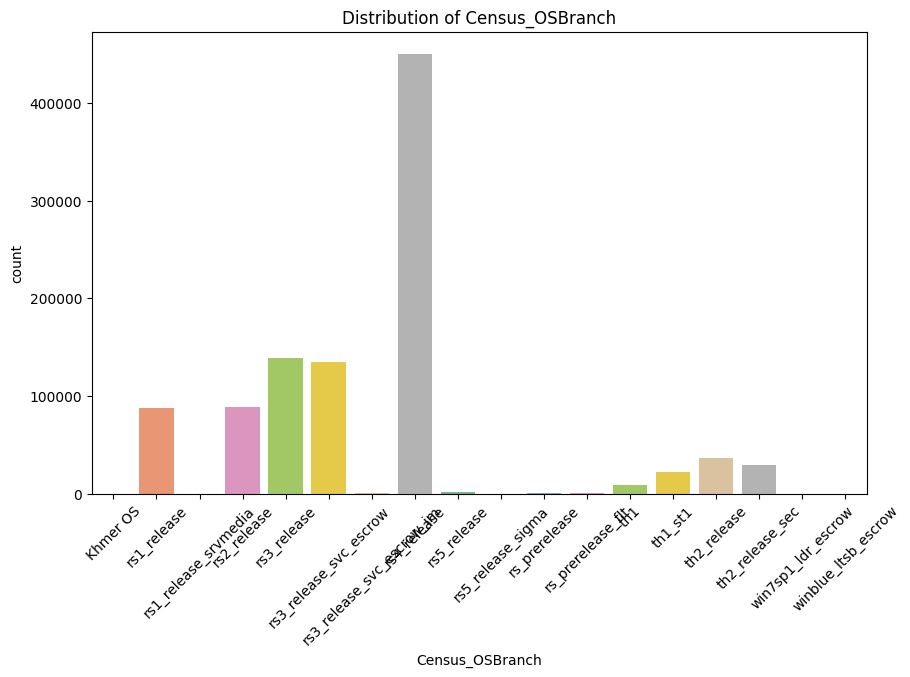

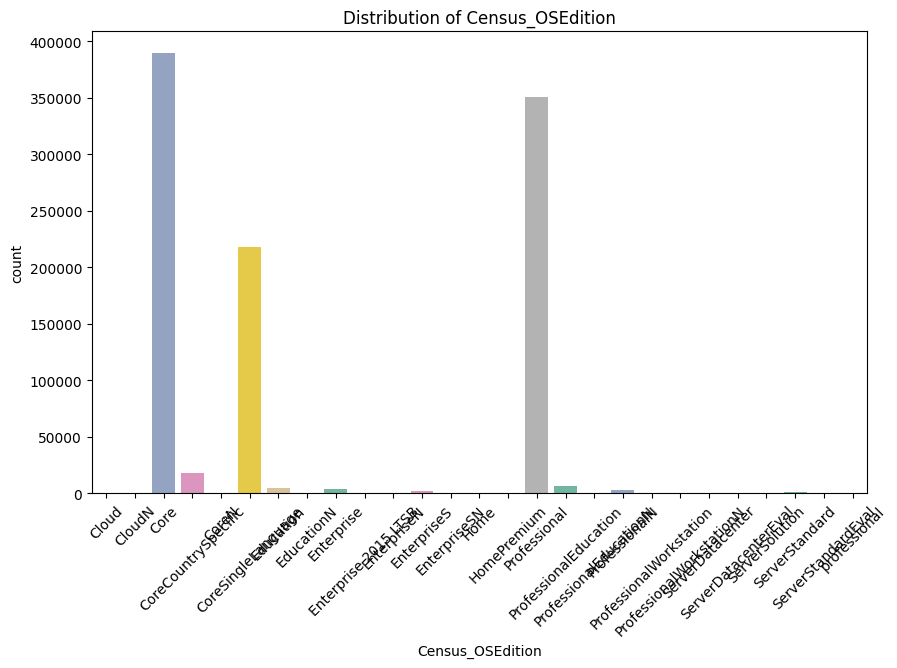

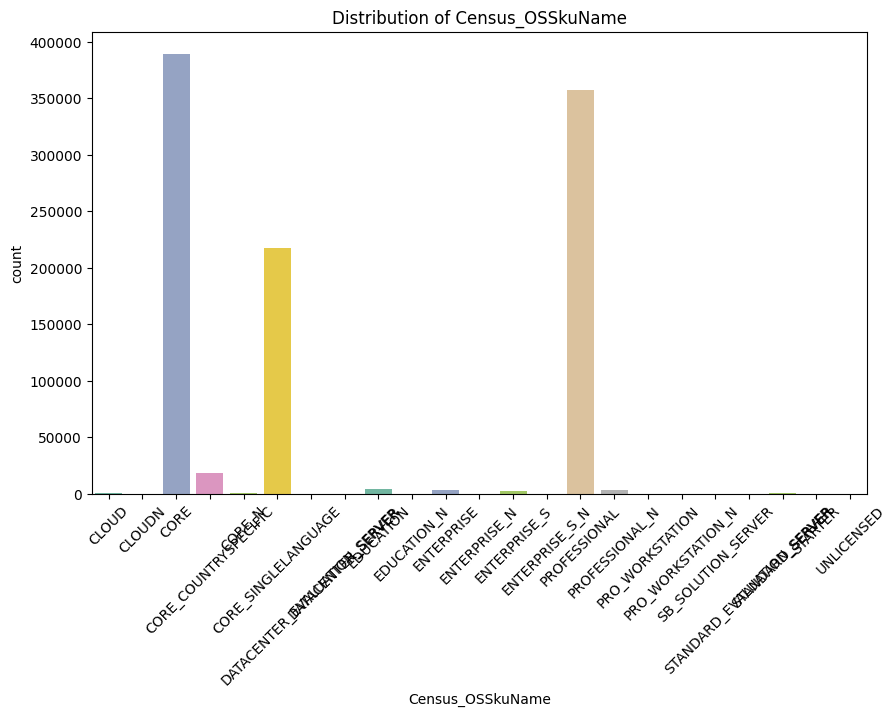

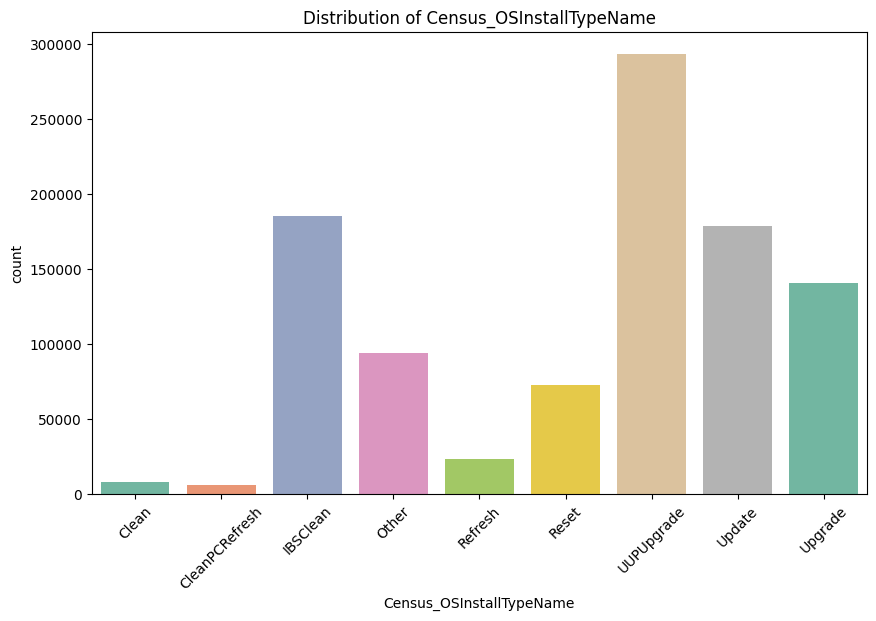

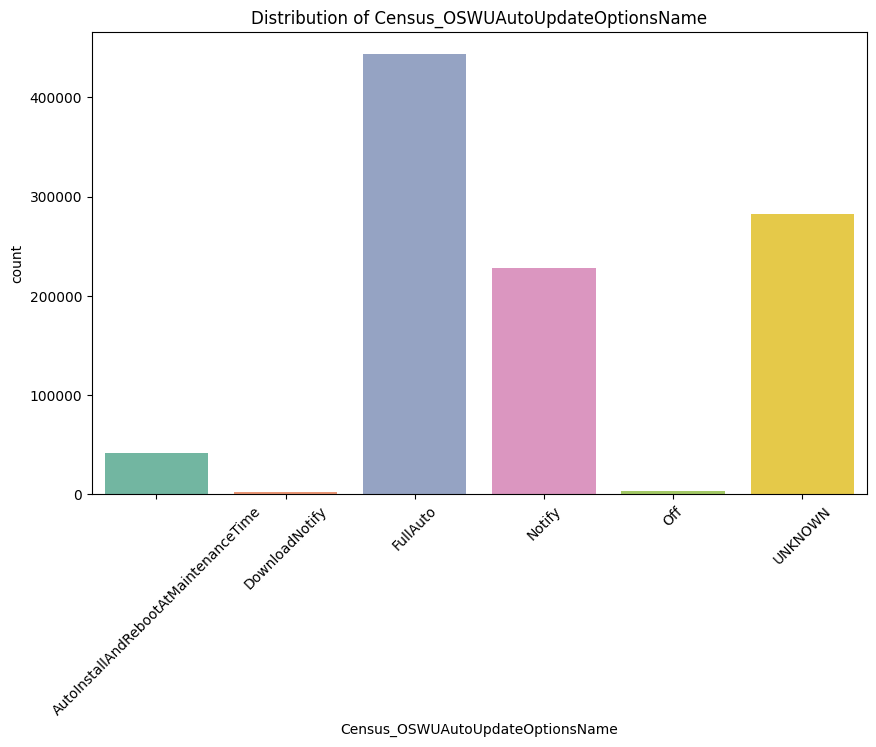

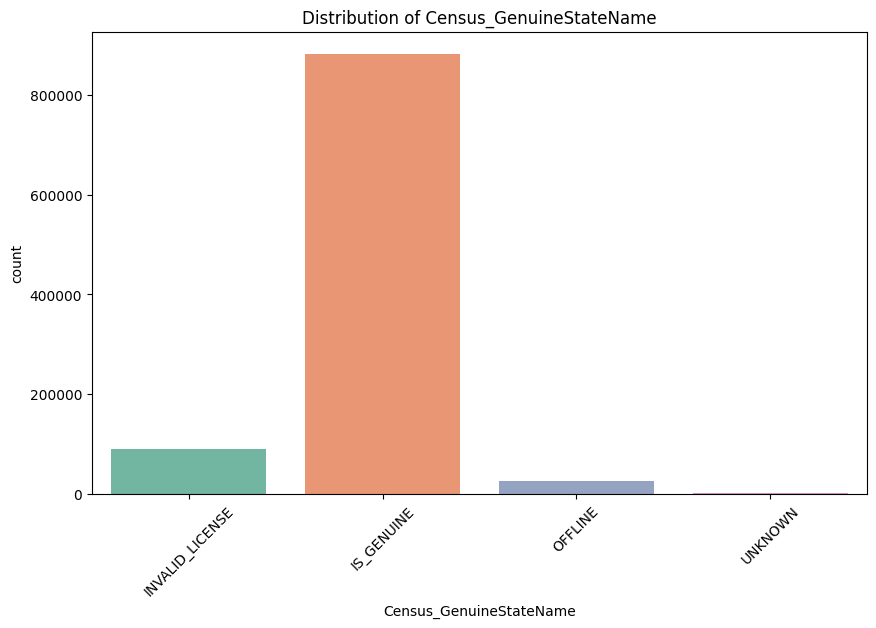

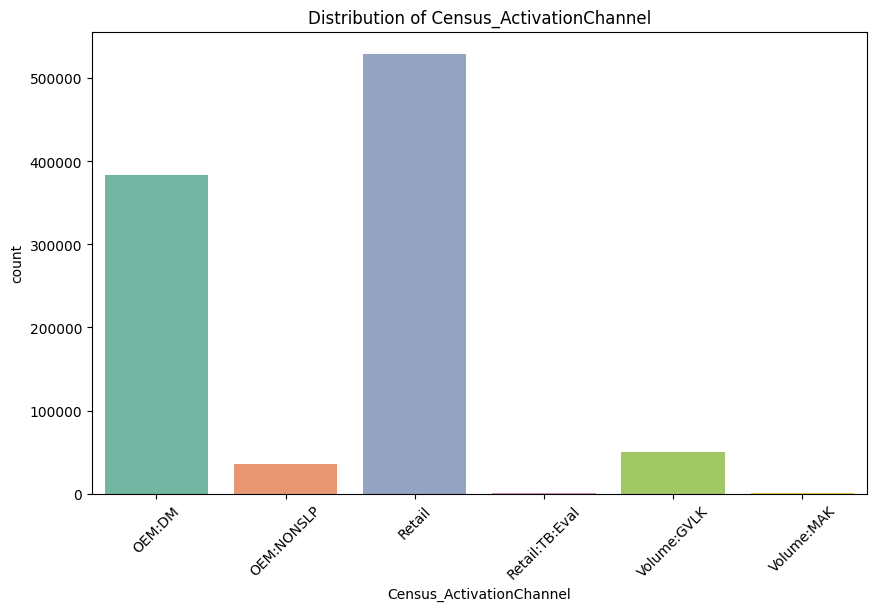

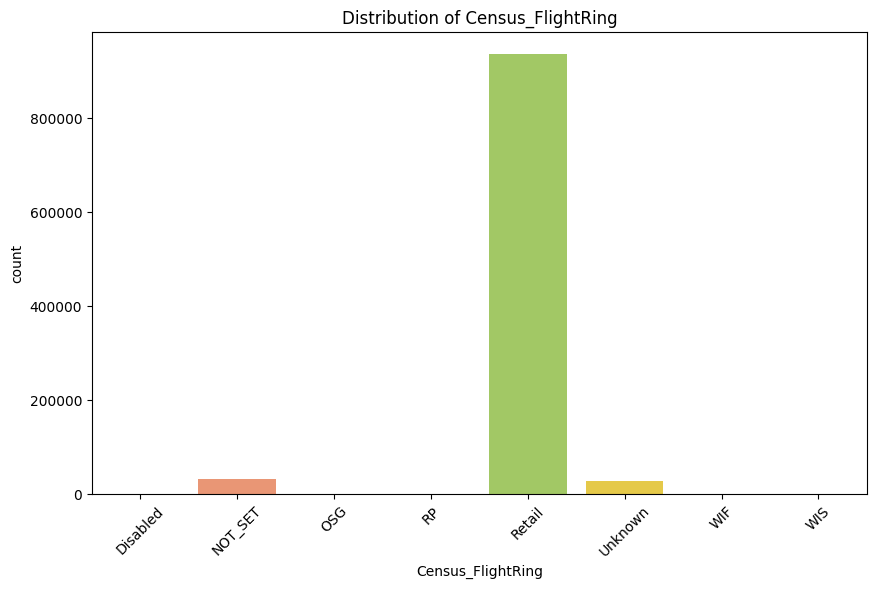

In [47]:

# Plotting the distribution of each categorical column
for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=train[col], palette='Set2')
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.show()


In [48]:
missing_values = train[categorical_cols].isnull().sum()

# Print columns with missing values and their count
print(missing_values[missing_values > 0])

OsBuildLab                           2
SmartScreen                     356618
Census_PrimaryDiskTypeName        1430
Census_ChassisTypeName              63
Census_PowerPlatformRoleName         6
dtype: int64


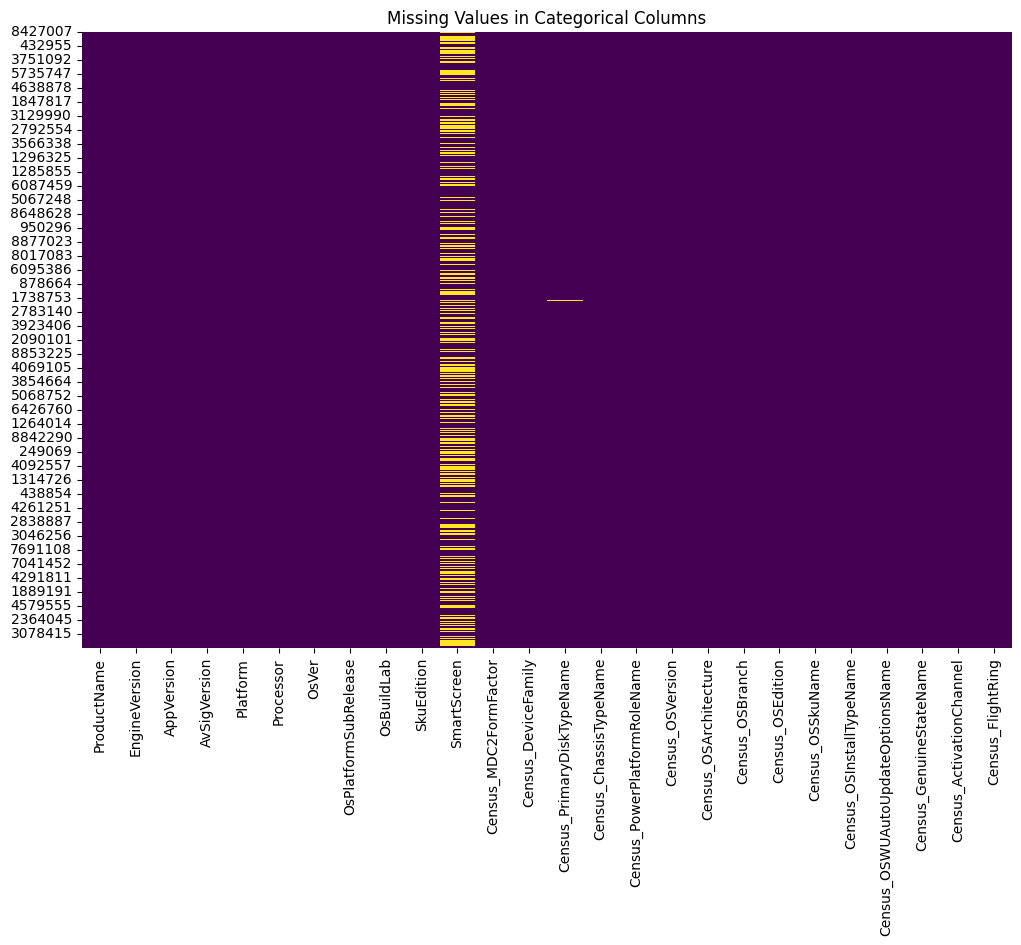

In [49]:
# Visualizing missing values using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(train[categorical_cols].isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values in Categorical Columns')
plt.show()


In [50]:
# Impute missing categorical values with mode
for col in categorical_cols:
    mode_value = train[col].mode()[0]
    train[col].fillna(mode_value, inplace=True)
    test[col].fillna(mode_value, inplace=True)  # Use the same mode from training data

In [51]:
# Verification: Check if there are any missing values remaining in the categorical columns
missing_train = train.isnull().sum()  # Count missing values in train data
missing_test = test.isnull().sum()    # Count missing values in test data

# Display the result
print("Missing values in train data after imputation:")
print(missing_train[missing_train > 0])  # Show columns with missing values in the training set

print("\nMissing values in test data after imputation:")
print(missing_test[missing_test > 0]) 

Missing values in train data after imputation:
Series([], dtype: int64)

Missing values in test data after imputation:
Series([], dtype: int64)


In [52]:
import pandas as pd
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
# Initialize LabelEncoder and OneHotEncoder
label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder(sparse=False, drop='first')

In [53]:
# Initialize Target Encoder (for target encoding)
target_encoder = ce.TargetEncoder(cols=['EngineVersion', 'AppVersion', 'AvSigVersion', 'OsVer', 'OsBuildLab', 
                                        'Census_OSVersion', 'Census_OSBranch', 'Census_OSSkuName', 
                                        'Census_OSInstallTypeName'])

In [54]:
one_hot_features = ['ProductName', 'Platform', 'Processor', 'SkuEdition', 'SmartScreen', 
                    'Census_MDC2FormFactor', 'Census_DeviceFamily', 'Census_PrimaryDiskTypeName', 
                    'Census_ChassisTypeName', 'Census_PowerPlatformRoleName', 'Census_OSEdition', 
                    'Census_OSSkuName', 'Census_OSInstallTypeName', 'Census_OSWUAutoUpdateOptionsName', 
                    'Census_GenuineStateName', 'Census_ActivationChannel', 'Census_FlightRing']

In [55]:
# Apply One-Hot Encoding
train_encoded = pd.get_dummies(train, columns=one_hot_features, drop_first=True)
test_encoded = pd.get_dummies(test, columns=one_hot_features, drop_first=True)

In [56]:
# 2. **Target Encoding for high cardinality features** (>10 unique categories)
# Apply Target Encoding to columns like 'EngineVersion', 'AppVersion', etc.
train_encoded[['EngineVersion', 'AppVersion', 'AvSigVersion', 'OsVer', 'OsBuildLab', 
               'Census_OSVersion', 'Census_OSBranch', 'Census_OSSkuName', 'Census_OSInstallTypeName']] = target_encoder.fit_transform(
    train[['EngineVersion', 'AppVersion', 'AvSigVersion', 'OsVer', 'OsBuildLab', 'Census_OSVersion', 
           'Census_OSBranch', 'Census_OSSkuName', 'Census_OSInstallTypeName']], train['HasDetections'])  

test_encoded[['EngineVersion', 'AppVersion', 'AvSigVersion', 'OsVer', 'OsBuildLab', 
              'Census_OSVersion', 'Census_OSBranch', 'Census_OSSkuName', 'Census_OSInstallTypeName']] = target_encoder.transform(
    test[['EngineVersion', 'AppVersion', 'AvSigVersion', 'OsVer', 'OsBuildLab', 'Census_OSVersion', 
          'Census_OSBranch', 'Census_OSSkuName', 'Census_OSInstallTypeName']])


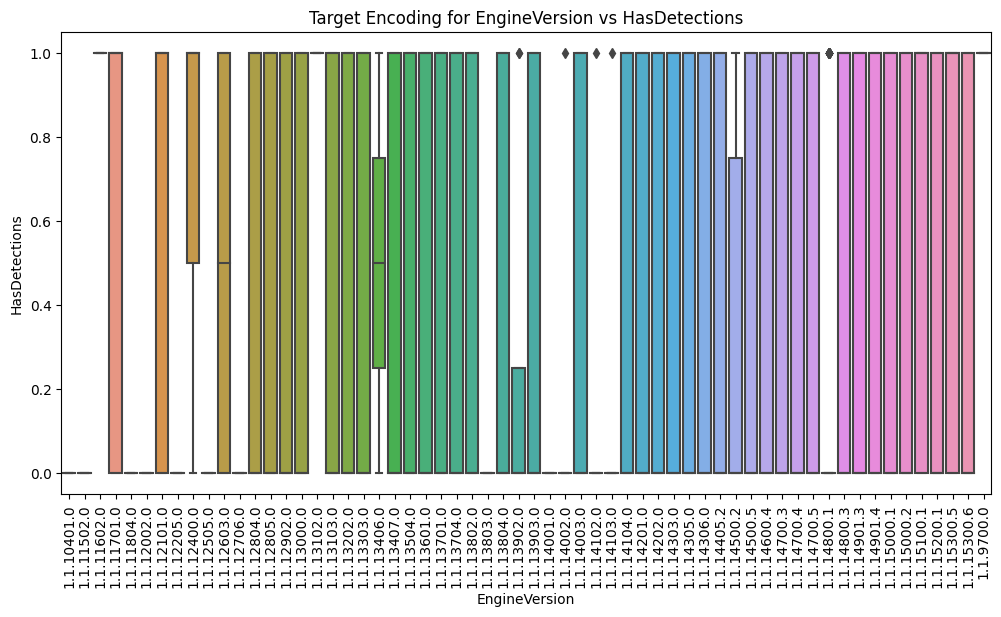

In [57]:
# Example: Target Encoding Effect on a Column
plt.figure(figsize=(12, 6))
sns.boxplot(x=train['EngineVersion'], y=train['HasDetections'])
plt.title('Target Encoding for EngineVersion vs HasDetections')
plt.xticks(rotation=90)
plt.show()


In [58]:
print(f"Shape of train data after encoding: {train_encoded.shape}")
print(f"Shape of test data after encoding: {test_encoded.shape}")

Shape of train data after encoding: (1000000, 225)
Shape of test data after encoding: (1000000, 220)


In [59]:
# Get the columns in train but not in test
train_columns = set(train_encoded.columns)
test_columns = set(test_encoded.columns)

# Find the difference (columns in train but not in test)
columns_in_train_not_test = list(train_columns - test_columns)

# Display the first 5 columns that exist in train but not in test
print(columns_in_train_not_test[:5])
print(f"Total columns in train but not in test: {len(columns_in_train_not_test)}")


['Census_OSEdition_CloudN', 'Census_OSEdition_Enterprise 2015 LTSB', 'Census_OSSkuName_PRO_WORKSTATION_N', 'SmartScreen_&#x03;', 'Census_OSSkuName_STARTER']
Total columns in train but not in test: 16


In [60]:
# Get the union of columns between train and test datasets
all_columns = train_encoded.columns.union(test_encoded.columns)

# Align columns for both datasets (adding missing columns with NaN for test)
train_encoded = train_encoded.reindex(columns=all_columns, fill_value=0)
test_encoded = test_encoded.reindex(columns=all_columns, fill_value=0)

print(f"Shape of train data after alignment: {train_encoded.shape}")
print(f"Shape of test data after alignment: {test_encoded.shape}")


Shape of train data after alignment: (1000000, 236)
Shape of test data after alignment: (1000000, 236)


# Splitting Data

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import joblib

In [62]:
y = train_encoded['HasDetections']
X = train_encoded.drop(columns=['HasDetections'])


# Split into train and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [63]:
non_numeric_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Display problematic columns
print("Columns with non-numeric data (causing issues with model fitting):")
print(non_numeric_cols)

Columns with non-numeric data (causing issues with model fitting):
['Census_OSArchitecture', 'OsPlatformSubRelease']


In [64]:
for col in non_numeric_cols:
    print(f"\nFirst few values in column '{col}':")
    print(X[col].head())


First few values in column 'Census_OSArchitecture':
8427007    amd64
8829090    amd64
2731904    amd64
1359513    amd64
236059     amd64
Name: Census_OSArchitecture, dtype: category
Categories (3, object): ['amd64', 'arm64', 'x86']

First few values in column 'OsPlatformSubRelease':
8427007    rs4
8829090    rs4
2731904    th2
1359513    rs4
236059     rs4
Name: OsPlatformSubRelease, dtype: category
Categories (9, object): ['prers5', 'rs1', 'rs2', 'rs3', ..., 'th1', 'th2', 'windows7', 'windows8.1']


In [65]:
categorical_cols = ['Census_OSArchitecture', 'OsPlatformSubRelease']  # List of categorical columns to encode
X_train_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
X_test_encoded = pd.get_dummies(test_encoded, columns=categorical_cols, drop_first=True)

In [66]:
all_columns = X_train_encoded.columns.union(X_test_encoded.columns)
X_train_encoded = X_train_encoded.reindex(columns=all_columns, fill_value=0)
X_test_encoded = X_test_encoded.reindex(columns=all_columns, fill_value=0)

In [67]:
print(f"Shape of train data after alignment: {X_train_encoded.shape}")
print(f"Shape of test data after alignment: {X_test_encoded.shape}")

Shape of train data after alignment: (1000000, 244)
Shape of test data after alignment: (1000000, 244)


In [68]:
y = train_encoded['HasDetections']
X = train_encoded.drop(columns=['HasDetections'])

In [69]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import randint

In [70]:
X_train, X_val, y_train, y_val = train_test_split(X_train_encoded, y, test_size=0.2, random_state=42)

In [71]:
rf_model = RandomForestClassifier(random_state=42, n_jobs=3) 
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=3, random_state=42)

In [72]:
y_pred = rf_model.predict(X_val)

In [73]:
print("Accuracy on validation set:", accuracy_score(y_val, y_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

Accuracy on validation set: 0.64389

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.67      0.65    100092
           1       0.65      0.62      0.63     99908

    accuracy                           0.64    200000
   macro avg       0.64      0.64      0.64    200000
weighted avg       0.64      0.64      0.64    200000



In [74]:
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

Confusion Matrix:
 [[66999 33093]
 [38129 61779]]


In [75]:
# 4. Hyperparameter Tuning using RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [76]:
grid_search = RandomizedSearchCV(rf_model, param_distributions=param_grid, n_iter=3, cv=3, n_jobs=-1, random_state=42, verbose=1)
# grid_search.fit(X_train, y_train)

In [77]:
X_train_sub, _, y_train_sub, _ = train_test_split(X_train, y_train, test_size=0.6, random_state=42)
grid_search.fit(X_train_sub, y_train_sub)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(n_jobs=3, random_state=42),
                   n_iter=3, n_jobs=-1,
                   param_distributions={'max_depth': [10, 20],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42, verbose=1)

In [78]:
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

In [79]:
# Best Hyperparameters and Best Model
print("Best Hyperparameters:", grid_search.best_params_)
best_rf_model = grid_search.best_estimator_

Best Hyperparameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}


In [80]:
# 5. Evaluating the Tuned Model
y_pred_tuned = best_rf_model.predict(X_val)
print("Accuracy on validation set with tuned model:", accuracy_score(y_val, y_pred_tuned))
print("\nClassification Report with tuned model:")
print(classification_report(y_val, y_pred_tuned))

Accuracy on validation set with tuned model: 0.643905

Classification Report with tuned model:
              precision    recall  f1-score   support

           0       0.65      0.64      0.64    100092
           1       0.64      0.65      0.65     99908

    accuracy                           0.64    200000
   macro avg       0.64      0.64      0.64    200000
weighted avg       0.64      0.64      0.64    200000



In [81]:
# 6. Cross-Validation on the Training Set
cv_scores = cross_val_score(best_rf_model,X_train_sub, y_train_sub, cv=3, scoring='accuracy')
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

Cross-validation scores: [0.64433236 0.64408861 0.64314777]
Mean cross-validation score: 0.6438562477860059


In [82]:
feature_importances = best_rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

In [83]:
print("Top 10 Important Features:")
print(feature_importance_df.head(10))

Top 10 Important Features:
                              Feature  Importance
231          SmartScreen_ExistsNotSet    0.082126
236          SmartScreen_RequireAdmin    0.058760
5                        AvSigVersion    0.058423
0           AVProductStatesIdentifier    0.045733
2                 AVProductsInstalled    0.039726
182  Census_SystemVolumeTotalCapacity    0.030288
184                    CityIdentifier    0.028044
186                     EngineVersion    0.026963
53   Census_FirmwareVersionIdentifier    0.026954
181   Census_ProcessorModelIdentifier    0.026341


In [84]:
# 8. Confusion Matrix and ROC-AUC for Model Evaluation
cm = confusion_matrix(y_val, y_pred_tuned)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[63956 36136]
 [35083 64825]]


In [85]:
# ROC-AUC Score
auc = roc_auc_score(y_val, best_rf_model.predict_proba(X_val)[:, 1])
print("ROC-AUC Score:", auc)

ROC-AUC Score: 0.7054373539821764


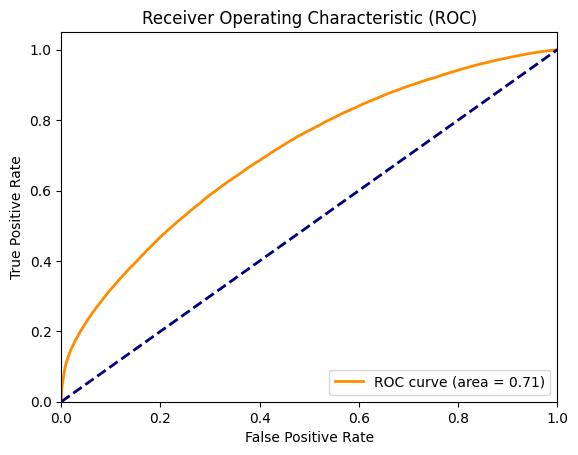

In [86]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, best_rf_model.predict_proba(X_val)[:, 1])
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

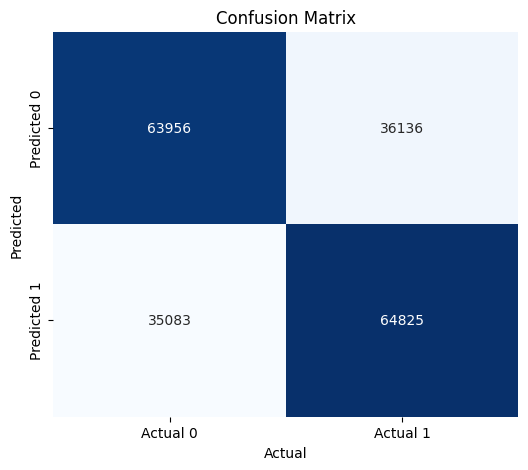

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Confusion matrix values
confusion_matrix = np.array([[63956, 36136],
                             [35083, 64825]])

# Create a heatmap for the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=["Actual 0", "Actual 1"], yticklabels=["Predicted 0", "Predicted 1"])
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion Matrix')
plt.show()
